In [ ]:
import sys
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import librosa

import pandas as pd

txt = pd.read_csv("file.txt")

sys.path.append("/home/aswin/Documents/Courses/Edx/Speech-Recognition/Labs/Speech-Recognition-master")
if 'M2_Speech_Signal_Processing.speech_sigproc' in sys.modules:
    del sys.modules['M2_Speech_Signal_Processing.speech_sigproc']
if 'M2_Speech_Signal_Processing.htk_featio' in sys.modules:
    del sys.modules['M2_Speech_Signal_Processing.htk_featio']
import M2_Speech_Signal_Processing.htk_featio as htk
import M2_Speech_Signal_Processing.speech_sigproc as sp

data_dir = '../Experiments'
wav_files = glob("../dataset/dev/*/*.wav")
strings = np.unique(pd.Series(wav_files).replace(to_replace=r"\.\.\/[a-z0-9]+\/dev\/[a-zA-Z0-9]+\/", value="", regex=True).values.flatten()).tolist()
feat_file = os.path.join(data_dir,'feat/1272-128104-0000.feat')
plot_output = True
feat_actors = dict()

for ii,wav_file in tqdm(enumerate(wav_files)):
    
    if not os.path.exists(os.path.join(data_dir,'feat')):
        os.mkdir(os.path.join(data_dir,'feat'))

    samp_rate = 48000

    x, s = librosa.core.load(wav_file)

    fe = sp.FrontEnd(samp_rate=s,mean_norm_feat=True,
             frame_duration=0.032, frame_shift=0.02274,hi_freq=8000)

    feat = fe.process_utterance(x)
    if strings[ii].split("-")[6].replace(".wav","") not in feat_actors:
        feat_actors[strings[ii].split("-")[6].replace(".wav","")] = []
    feat_actors[strings[ii].split("-")[6].replace(".wav","")].append(feat)
    


In [ ]:
from sklearn.decomposition import FastICA

ica_mixing_array = []
n_actors = len(feat_actors)
for i in tqdm(range(len(feat_actors['01']))):
    # for each string
    data = np.concatenate([feat_actors[actor][i] for actor in feat_actors],axis=1)
    ica = FastICA(n_components=n_actors)
    ica.fit(data.T)
    ica_mixing_array.append(ica.mixing_)

In [ ]:
!pip install factor_analysis

In [ ]:
import factor_analysis

In [ ]:
from factor_analysis.factors import Factor
from factor_analysis.noise import Noise

In [ ]:
import tensorflow as tf
factors = {}
noises = {}

for ii,ica_mixing in tqdm(enumerate(ica_mixing_array)):
    f = factor_analysis.factors.Factor(ica_mixing, 
factor_analysis.posterior.Posterior(np.cov(ica_mixing.T), 
 np.concatenate([np.mean(ica_mixing,axis=0).reshape(1,-1)/ica_mixing.shape[1]]*ica_mixing.shape[1],axis=0)))

    noise = factor_analysis.noise.Noise(f, f.posterior)

    with tf.Session() as sess:
        factors[strings[ii].split("/")[-1].replace(".wav","")] = f.create_factor().eval()
        noises[strings[ii].split("/")[-1].replace(".wav","")] = noise.create_noise(f.create_factor()).eval()

/home/aswin/.local/lib/python3.6/site-packages/cntk/cntk_py_init.py:56: UserWarning: Unsupported Linux distribution (ubuntu-18.04). CNTK supports Ubuntu 16.04 and above, only.
  warnings.warn('Unsupported Linux distribution (%s-%s). CNTK supports Ubuntu 16.04 and above, only.' % (__my_distro__, __my_distro_ver__))
/home/aswin/.local/lib/python3.6/site-packages/cntk/cntk_py_init.py:98: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Linux-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignore the (likely) GPU-specific warning!
#####

Episode: 0. Average reward for episode 0.014849. Variance 0.024784
Episode: 0. Average loss for episode -28.700505
Episode: 20. Average reward for episode 0.179881. Variance 0.259291
Episode: 20. Average loss for episode -78.092690
Episode: 40. Average reward for episode -0.387188. Variance 0.235020
Episode: 40. Average loss for episode 40.910318
Episode: 60. Average reward for episode -0.195996. Variance 0.249893
Episode: 60. Average loss for episode -69.341102
Episode: 80. Average reward for episode -0.006073. Variance 0.250873
Episode: 80. Average loss for episode 10.773092
Episode: 100. Average reward for episode -0.144089. Variance 0.231689
Episode: 100. Average loss for episode 122.801299
Episode: 120. Average reward for episode 0.054377. Variance 0.221193
Episode: 120. Average loss for episode 42.036678
Episode: 140. Average reward for episode 0.125776. Variance 0.229335
Episode: 140. Average loss for episode -52.085890
Episode: 160. Average reward for episode 0.198149. Variance

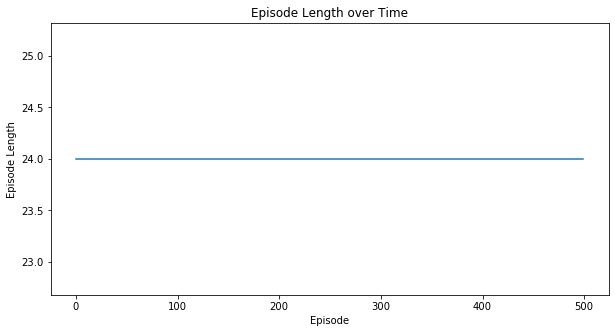

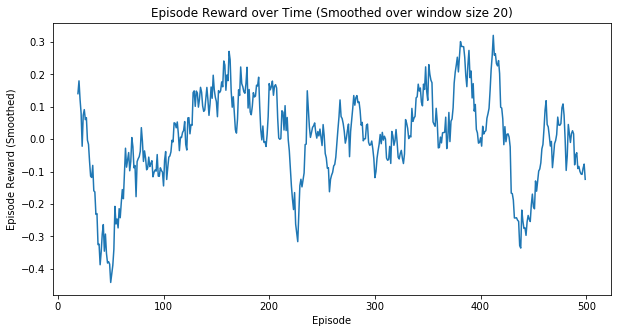

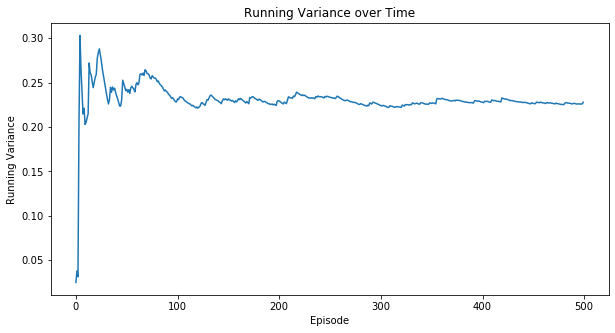

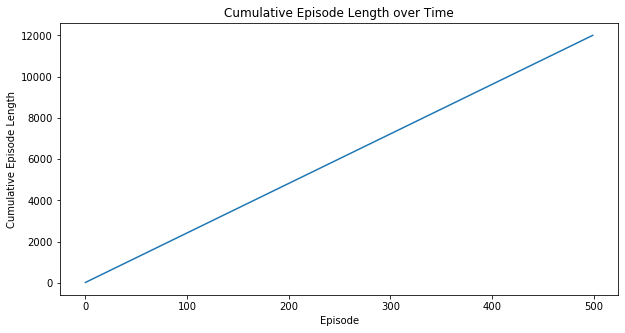

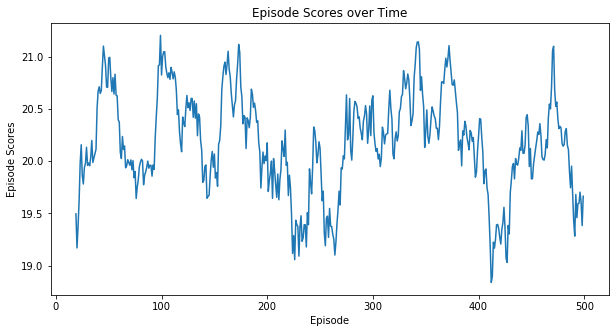

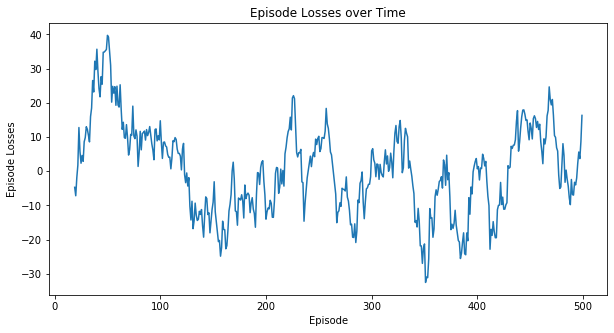

 50%|█████     | 1/2 [02:31<02:31, 151.61s/it]

Episode: 0. Average reward for episode -0.056929. Variance 0.227458
Episode: 0. Average loss for episode -28.715022
Episode: 20. Average reward for episode 0.179881. Variance 0.229152
Episode: 20. Average loss for episode -78.106431
Episode: 40. Average reward for episode -0.387188. Variance 0.228760
Episode: 40. Average loss for episode 40.910449
Episode: 60. Average reward for episode -0.195996. Variance 0.230996
Episode: 60. Average loss for episode -69.336819
Episode: 80. Average reward for episode -0.006073. Variance 0.231695
Episode: 80. Average loss for episode 10.776902
Episode: 100. Average reward for episode -0.144089. Variance 0.229306
Episode: 100. Average loss for episode 122.808149
Episode: 120. Average reward for episode 0.054377. Variance 0.227169
Episode: 120. Average loss for episode 42.044816
Episode: 140. Average reward for episode 0.125776. Variance 0.228409
Episode: 140. Average loss for episode -52.094499
Episode: 160. Average reward for episode 0.198149. Varianc

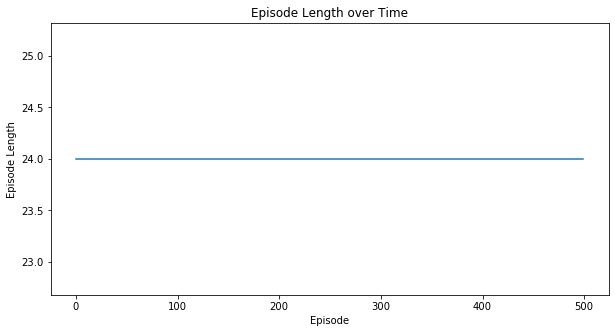

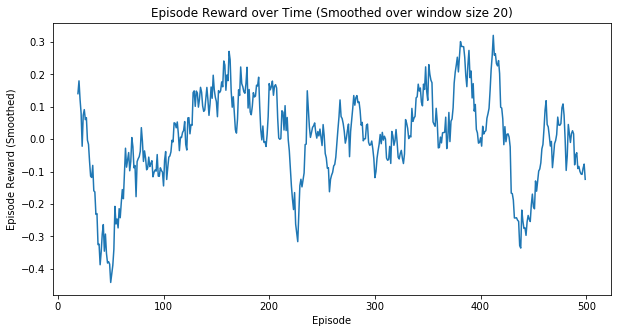

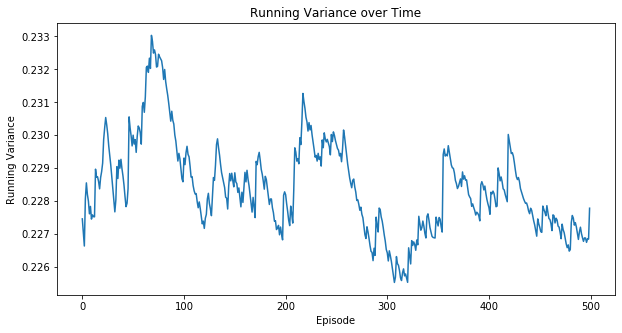

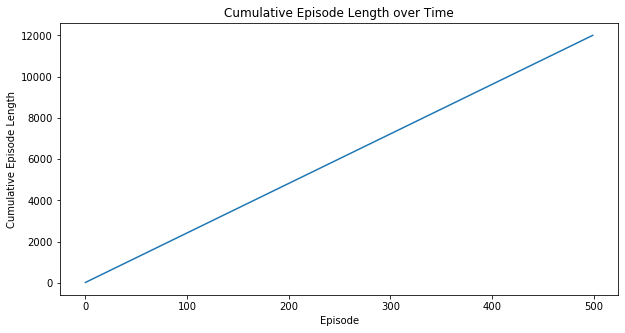

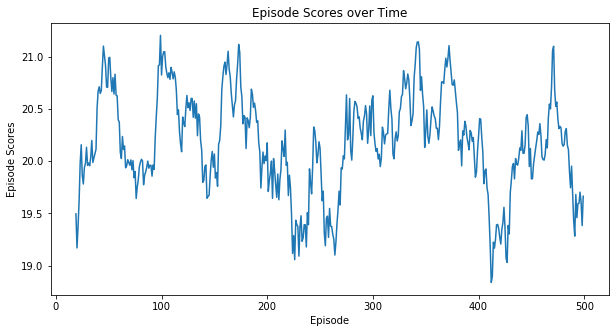

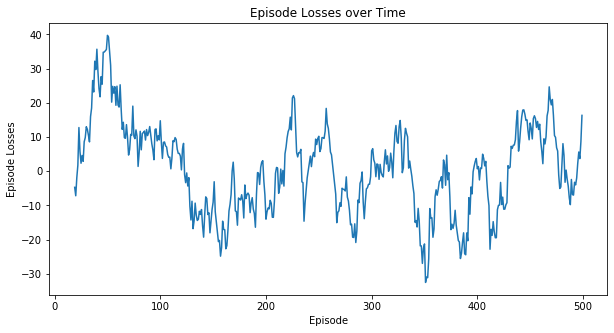

100%|██████████| 2/2 [04:56<00:00, 148.16s/it]


In [1]:
import cntk as C
import numpy as np
from tqdm import tqdm
from cntk.losses import binary_cross_entropy, cross_entropy_with_softmax, weighted_binary_cross_entropy

from lib.running_variance import RunningVariance
from itertools import count
from lib import plotting
from lib.envs.bandit import BanditEnv, ActionSpace

C.cntk_py.force_deterministic_algorithms()

import pickle

feat_actors = pickle.load(open("feat_actors.pkl", "rb"))
ica_mixing_array = pickle.load(open("ica_mixing_array.pkl", "rb"))
factors = pickle.load(open("factors.pkl", "rb"))
noises = pickle.load(open("noises.pkl", "rb"))

import scipy

from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist

from abc import ABC, abstractmethod
from collections import defaultdict, namedtuple
import math
from cntk.layers import Sequential, Dense, GRU
from cntk.layers import *
from sklearn.preprocessing import MinMaxScaler
import itertools
import matplotlib.pyplot as plt

noise_values = np.array(list(noises.values()))
noise_mean = np.mean(noise_values)
noise_std = np.std(noise_values)
scaler = MinMaxScaler(feature_range=(0,6)).fit((noise_values - noise_mean)/noise_std)

NOISE_PARAM = 4.30
MAX_CLUSTERS = 11

def run_mcts(clusters, noise):
    
    _HCC = namedtuple("HierarchicalCluster", "cluster noise terminal")

    class HierarchicalCluster(_HCC, ABC):

        @staticmethod
        def has_children(cluster, n):
            cluster_idxs = np.where(clusters==cluster)[0]
            return n == np.min(noise[cluster_idxs])
        
        def find_children(self):
            cluster_idxs = np.where(clusters==(self.cluster+1))[0]
            return {
                HierarchicalCluster(cluster=clusters[idx], noise=noise[idx], 
                    terminal=HierarchicalCluster.set_terminal(
                        clusters[idx], noise[idx])) for idx in cluster_idxs
            }

        def find_random_child(self):
            cluster_no = np.random.choice(list(set(np.arange(1,MAX_CLUSTERS+1,1).tolist()) - set([self.cluster])))
            noise_value = np.random.choice(noise[clusters==cluster_no])
            return HierarchicalCluster(cluster=cluster_no, noise=noise_value, 
            terminal=HierarchicalCluster.set_terminal(cluster_no, noise_value))

        @staticmethod
        def set_terminal(cluster, n):
            return cluster == 9 or HierarchicalCluster.has_children(cluster, n)
        
        def is_terminal(self):
            return self.terminal

        def reward(self):
            return (MAX_CLUSTERS - self.cluster) / MAX_CLUSTERS + NOISE_PARAM - \
        abs(scaler.transform(((np.array([self.noise]*24) - noise_mean) / noise_std).reshape(1,-1)).flatten()[0])
        
    return HierarchicalCluster

class MCTS:

    def __init__(self, exploration_weight=1, env=None):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight
        self.env = env

    def choose(self, node):
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score), np.max(list(map(score, self.children[node])))

    def do_rollout(self, node):
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        invert_reward = True
        while True:
            if node.is_terminal():
                reward = node.reward()
                self.env.is_reset = True
                return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        
        log_N_vertex = math.log(self.N[node])
        
        def uct(item):
            return self.Q[item] / self.N[item] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[item]
            )
        
        return max(self.children[node], key=uct)

def state_space_model(factors, noises, ica_mixing_array):
    def state_space(state):
        factor = factors[state]
        noise = noises[state]
        ica_mixing = ica_mixing_array[state]
        
        return ica_mixing, factor, noise
    
    def non_deterministic_hierarchical_clustering(model, n_clusters=MAX_CLUSTERS):
        factor = factors[model]
        Z = ward(pdist(factor))
        clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
        
        return clusters
    
    def least_noise_model(model, clusters, env=None):
        noise = noises[model]
        node = run_mcts(clusters, noise)(cluster=1,noise=noise[0], terminal=False)
        mcts = MCTS(env=env)
        
        while True:
            for i in range(25):
                mcts.do_rollout(node)
            node, score = mcts.choose(node)
            if node.terminal:
                break
        state_selected = np.where((clusters == node.cluster) & (noise == node.noise))[0][0]
        return state_selected, score
    
    def marginal_model(action):
        state = ica_mixing_array[action]
        
        return state
    
    return state_space, non_deterministic_hierarchical_clustering, least_noise_model, marginal_model

state_space, non_deterministic_hierarchical_clustering, least_noise_model, marginal_model = \
state_space_model(factors, noises, ica_mixing_array)

class PGCREnv(BanditEnv):
    def __init__(self, num_actions = 10, observation_space = None, distribution = "factor_model", evaluation_seed=387):
        super(BanditEnv, self).__init__()
        
        self.action_space = ActionSpace(range(num_actions))
        self.distribution = distribution
        
        self.observation_space = observation_space
        
        np.random.seed(evaluation_seed)
        
        self.reward_parameters = None
        if distribution == "bernoulli":
            self.reward_parameters = np.random.rand(num_actions)
        elif distribution == "normal":
            self.reward_parameters = (np.random.randn(num_actions), np.random.rand(num_actions))
        elif distribution == "heavy-tail":
            self.reward_parameters = np.random.rand(num_actions)
        elif distribution == "factor_model":
            self.reward_parameters = (np.array(list(factors.values())).sum(axis=2), 
                          np.array(list(noises.values())))
        else:
            print("Please use a supported reward distribution", flush = True)
            sys.exit(0)
        
        if distribution != "normal":
            self.optimal_arm = np.argmax(self.reward_parameters)
        else:
            self.optimal_arm = np.argmax(self.reward_parameters[0])
    
    def reset(self):
        self.is_reset = True
        action = np.random.randint(0,action_count)
        return ica_mixing_array[action], list(factors.keys())[action]
    
    def compute_gap(self, action):
        if self.distribution == "factor_model":
            gap = np.absolute(self.reward_parameters[0][self.optimal_arm] - self.reward_parameters[0][action])
        elif self.distribution != "normal":
            gap = np.absolute(self.reward_parameters[self.optimal_arm] - self.reward_parameters[action])
        else:
            gap = np.absolute(self.reward_parameters[0][self.optimal_arm] - self.reward_parameters[0][action])
        return gap
    
    def step(self, action):
        self.is_reset = False
        
        valid_action = True
        if (action is None or action < 0 or action >= self.action_space.n):
            print("Algorithm chose an invalid action; reset reward to -inf", flush = True)
            reward = float("-inf")
            gap = float("inf")
            valid_action = False
        
        if self.distribution == "bernoulli":
            if valid_action:
                reward = np.random.binomial(1, self.reward_parameters[action])
                gap = self.reward_parameters[self.optimal_arm] - self.reward_parameters[action]
        elif self.distribution == "normal":
            if valid_action:
                reward = self.reward_parameters[0][action] + self.reward_parameters[1][action] * np.random.randn()
                gap = self.reward_parameters[0][self.optimal_arm] - self.reward_parameters[0][action]
        elif self.distribution == "heavy-tail":
            if valid_action:
                reward = self.reward_parameters[action] + np.random.standard_cauchy()
                gap = self.reward_parameters[self.optimal_arm] - self.reward_parameters[action]        #HACK to compute expected gap
        elif self.distribution == "factor_model":
            if valid_action:
                reward = np.linalg.norm(
                    self.reward_parameters[0][action],1
                ) + \
                np.linalg.norm(
                    self.reward_parameters[1][action],1
                ) * np.random.randn()
        else:
            print("Please use a supported reward distribution", flush = True)
            sys.exit(0)
            
        observation = marginal_model(action)
        
        return(observation, list(factors.keys())[action], reward, self.is_reset, '')

state_dim = 24 # Dimension of state space
action_count = 60 # Number of actions
hidden_size = 256 # Number of hidden units
update_frequency = 20

# The policy network maps an observation to a probability of taking action 0 or 1.
observations = C.sequence.input_variable((1,120), np.float32, name="obs")
layer3 = Recurrence(GRU(120))
layer4 = layer3(observations)
W1 = C.parameter(shape=(120, hidden_size), init=C.glorot_uniform(), name="W1")
b1 = C.parameter(shape=hidden_size, name="b1")
layer1 = C.relu(C.times(layer4, W1) + b1)
W2 = C.parameter(shape=(hidden_size, state_dim), init=C.glorot_uniform(), name="W2")
b2 = C.parameter(shape=state_dim, name="b2")
layer2 = C.softmax(C.times(layer1, W2) + b2)
output = layer2

# Label will tell the network what action it should have taken.
label = C.sequence.input_variable((1,state_dim), np.float32, name="label")
# return_weight is a scalar containing the discounted return. It will scale the PG loss.
return_weight = C.sequence.input_variable(1, np.float32, name="weight")

loss = C.reduce_mean(C.log(C.square(output - label) + 1e-4) * return_weight, axis=0, name='loss')

# Build the optimizer
lr_schedule = C.learning_rate_schedule(lr=1e-3, unit=C.UnitType.sample)
m_schedule = C.momentum_schedule(0.99)
vm_schedule = C.momentum_schedule(0.999)
optimizer = C.adam([W1, W2, b1, b2], lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)

# Create a buffer to manually accumulate gradients
gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

def discount_rewards(r, factor_model, gamma=0.999):
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r,dtype=np.float32)
    running_add = 0
    f_ = 0
    f = np.linalg.norm(factor_model[0],1)
    running_add = f
    for t in reversed(range(0, r.size)):
        if (t < (r.size - 1) and r.size >= 2):
            f_ = np.linalg.norm(factor_model[t+1],1)
            f = np.linalg.norm(factor_model[t],1)
            running_add = running_add + gamma * f_ - f
        running_add = running_add + r[t]
        discounted_r[t] = running_add
    return discounted_r

running_variance = RunningVariance()
reward_sum = 0

max_number_of_episodes = 500
num_epochs = 2

epoch_stats = []
net_actions = []
net_rewards = []
net_scores = []

for epoch in tqdm(range(num_epochs)):
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(max_number_of_episodes),
        episode_rewards=np.zeros(max_number_of_episodes),
        episode_running_variance=np.zeros(max_number_of_episodes),
        episode_scores=np.zeros(max_number_of_episodes),
        losses=np.zeros(max_number_of_episodes))

    env = PGCREnv(num_actions = action_count, observation_space = np.zeros((state_dim,1)))
    
    for episode_number in range(max_number_of_episodes):
        states, rewards, labels, scores = [],[],[],[]
        done = False

        observation, model = env.reset()
        factor_sequence = []
        t = 1
        for state_dim_i in range(state_dim):
            done = False
            while not done:
                
                state = np.ascontiguousarray(np.reshape(observation[:,state_dim_i], [1,120]).astype(np.float32))
                states.append(state)

                prob = output.eval(arguments={observations: state})[0][0][0]
                action_selected = prob[np.argmax(prob)]
                is_reset = False
                score = 0.0
                action, score = least_noise_model(
                    model, non_deterministic_hierarchical_clustering(model), env=env
                )
                is_reset = env.is_reset
                
                net_actions.append(action)

                z = np.ones((1,state_dim)).astype(np.float32) * 1.25/120
                z[:,state_dim_i] = 0.75
                labels.append(z)
                
                # step the environment and get new measurements
                observation, model, reward, done, _ = env.step(action)

                done = is_reset if is_reset is True else False

                observation = np.ascontiguousarray(observation)

                net_rewards.append(reward)
                net_scores.append(score)

                reward_sum += float(reward)

                # Record reward (has to be done after we call step() to get reward for previous action)
                rewards.append(float(reward))

                factor_sequence.append(list(factors.values())[action])

                stats.episode_rewards[episode_number] += reward
                stats.episode_lengths[episode_number] = t
                stats.episode_scores[episode_number] += score

                t += 1

        # Stack together all inputs, hidden states, action gradients, and rewards for this episode
        epr = np.vstack(rewards).astype(np.float32)

        # Compute the discounted reward backwards through time.
        discounted_epr = discount_rewards(epr, factor_sequence)
        
        for state, _label, discounted_reward in tuple(zip(states,labels,discounted_epr)):
            # Keep a running estimate over the variance of of the discounted rewards
            running_variance.add(discounted_reward.sum())

            # Forward pass
            arguments = {observations: state, label: _label, 
                 return_weight: discounted_reward}
            state, outputs_map = loss.forward(arguments, outputs=loss.outputs,
                  keep_for_backward=loss.outputs)

            # Backward pass
            root_gradients = {v: np.ones_like(o) for v, o in outputs_map.items()}
            vargrads_map = loss.backward(state, root_gradients, variables=set([W1, W2, b1, b2]))

            stats.losses[episode_number] += np.mean(loss.eval(arguments)[0])

            for var, grad in vargrads_map.items():
                gradBuffer[var.name] += grad

        # Only update every 20 episodes to reduce noise
        if episode_number % update_frequency == 0:
            grads = {W1: gradBuffer['W1'].astype(np.float32),
                     W2: gradBuffer['W2'].astype(np.float32),
                    b1: gradBuffer['b1'].astype(np.float32),
                    b2: gradBuffer['b2'].astype(np.float32)}
            updated = optimizer.update(grads, update_frequency)

            # reset the gradBuffer
            gradBuffer = dict((var.name, np.zeros(shape=var.shape))
                      for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

            print('Episode: %d. Average reward for episode %f. Variance %f' % (episode_number, reward_sum / update_frequency, running_variance.get_variance()))

            print('Episode: %d. Average loss for episode %f' % (episode_number, stats.losses[episode_number]))

            reward_sum = 0

        stats.episode_running_variance[episode_number] = running_variance.get_variance()
    
    plotting.plot_pgresults(stats)
    epoch_stats.append(stats)


### Beta distribution

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
units_var = tf.Variable(tf.ones(stats.episode_scores.shape[0]))

def units_per_cell():
    return units_var

x = tf.Variable(tf.ones(stats.episode_scores.shape[0]), shape=stats.episode_scores.shape)
alpha = 0.5
beta = 0.5
dist = scipy.stats.beta(alpha, beta)
lr = 1e-1
scaler = MinMaxScaler(feature_range=(0,1)).fit(stats.episode_scores.reshape(-1,1))
scaled_scores = scaler.transform(stats.episode_scores.reshape(-1,1)).flatten()
scaled_scores.sort()

optimizer = tf.train.GradientDescentOptimizer(lr)

y = MinMaxScaler(feature_range=(0,1)).fit_transform(dist.pdf(np.linspace(1e-3,0.999,500)).reshape(-1,1)).flatten()
y.sort()
y_estimated = scaled_scores * units_per_cell()

loss = tf.reduce_mean(tf.abs(y_estimated - y))

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
local = tf.local_variables_initializer()
n_iter = 200000

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    sess.run(local)
    loss_values = []
    train_data = []
    y_vals = []
    captured = []
    for step in tqdm(range(n_iter)):
        _, loss_val, units_val, y_val = sess.run([train, loss, units_var, y_estimated])
        loss_values.append(loss_val)
        y_vals.append(y_val)
        if step % 1000 == 0:
            print(step, loss_val)

W0223 11:35:30.920851 139917768674176 deprecation.py:323] From /home/aswin/anaconda3/envs/enscalo_test/lib/python3.6/site-packages/tensorflow_core/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
  0%|          | 395/200000 [00:00<4:01:34, 13.77it/s]

0 0.4421673


  1%|          | 1207/200000 [00:00<59:04, 56.09it/s]  

1000 0.39103782


  1%|          | 2245/200000 [00:01<11:16, 292.45it/s]

2000 0.34001127


  2%|▏         | 3271/200000 [00:01<03:16, 1003.51it/s]

3000 0.28953275


  2%|▏         | 4356/200000 [00:02<01:48, 1798.80it/s]

4000 0.24011299


  3%|▎         | 5225/200000 [00:02<01:36, 2013.38it/s]

5000 0.19263512


  3%|▎         | 6326/200000 [00:03<01:33, 2081.79it/s]

6000 0.1485147


  4%|▎         | 7302/200000 [00:03<01:28, 2188.57it/s]

7000 0.11022324


  4%|▍         | 8384/200000 [00:04<01:35, 2010.44it/s]

8000 0.08006104


  5%|▍         | 9257/200000 [00:04<01:29, 2124.42it/s]

9000 0.057287145


  5%|▌         | 10320/200000 [00:05<01:36, 1958.51it/s]

10000 0.040839665


  6%|▌         | 11228/200000 [00:05<01:27, 2159.03it/s]

11000 0.029627958


  6%|▌         | 12466/200000 [00:05<01:07, 2796.04it/s]

12000 0.021958586


  7%|▋         | 13409/200000 [00:06<01:01, 3011.39it/s]

13000 0.016371094


  7%|▋         | 14275/200000 [00:06<01:09, 2662.83it/s]

14000 0.012420871


  8%|▊         | 15308/200000 [00:07<01:19, 2311.31it/s]

15000 0.009555344


  8%|▊         | 16238/200000 [00:07<01:21, 2267.78it/s]

16000 0.0075712027


  9%|▊         | 17372/200000 [00:07<01:30, 2021.28it/s]

17000 0.00623954


  9%|▉         | 18294/200000 [00:08<01:21, 2224.61it/s]

18000 0.0051768557


 10%|▉         | 19378/200000 [00:08<01:29, 2029.23it/s]

19000 0.004328563


 10%|█         | 20318/200000 [00:09<01:22, 2186.98it/s]

20000 0.0036517314


 11%|█         | 21177/200000 [00:09<01:31, 1963.53it/s]

21000 0.0030751505


 11%|█         | 22313/200000 [00:10<01:19, 2246.09it/s]

22000 0.0026941153


 12%|█▏        | 23534/200000 [00:10<01:02, 2810.94it/s]

23000 0.002375049


 12%|█▏        | 24435/200000 [00:11<01:04, 2713.82it/s]

24000 0.0020846815


 13%|█▎        | 25254/200000 [00:11<01:09, 2527.50it/s]

25000 0.0018516734


 13%|█▎        | 26301/200000 [00:11<01:13, 2361.07it/s]

26000 0.0016601256


 14%|█▎        | 27315/200000 [00:12<01:10, 2462.42it/s]

27000 0.0014945689


 14%|█▍        | 28502/200000 [00:12<01:00, 2853.40it/s]

28000 0.0013431341


 15%|█▍        | 29396/200000 [00:12<00:58, 2910.97it/s]

29000 0.0011951388


 15%|█▌        | 30302/200000 [00:13<00:58, 2895.35it/s]

30000 0.0010688745


 16%|█▌        | 31137/200000 [00:13<01:13, 2302.20it/s]

31000 0.0009645455


 16%|█▌        | 32262/200000 [00:14<01:20, 2073.33it/s]

32000 0.0008732985


 17%|█▋        | 33329/200000 [00:14<01:24, 1979.84it/s]

33000 0.00079121377


 17%|█▋        | 34524/200000 [00:15<01:11, 2315.31it/s]

34000 0.00071920303


 18%|█▊        | 35418/200000 [00:15<01:00, 2717.32it/s]

35000 0.00065500103


 18%|█▊        | 36303/200000 [00:15<00:58, 2795.72it/s]

36000 0.0005926601


 19%|█▊        | 37364/200000 [00:16<01:07, 2404.59it/s]

37000 0.0005366652


 19%|█▉        | 38401/200000 [00:16<01:06, 2446.48it/s]

38000 0.0004985251


 20%|█▉        | 39357/200000 [00:17<01:09, 2308.51it/s]

39000 0.00047080696


 20%|██        | 40248/200000 [00:17<01:17, 2065.97it/s]

40000 0.00044308894


 21%|██        | 41332/200000 [00:18<01:13, 2163.39it/s]

41000 0.00042013376


 21%|██        | 42300/200000 [00:18<01:10, 2241.83it/s]

42000 0.00040308645


 22%|██▏       | 43286/200000 [00:18<01:12, 2170.77it/s]

43000 0.0003874197


 22%|██▏       | 44165/200000 [00:19<01:16, 2028.80it/s]

44000 0.00037175257


 23%|██▎       | 45290/200000 [00:19<01:14, 2072.99it/s]

45000 0.00035608505


 23%|██▎       | 46320/200000 [00:20<01:17, 1989.07it/s]

46000 0.00034041746


 24%|██▎       | 47323/200000 [00:20<01:03, 2387.74it/s]

47000 0.00032766658


 24%|██▍       | 48564/200000 [00:21<00:51, 2913.55it/s]

48000 0.00031664336


 25%|██▍       | 49494/200000 [00:21<00:51, 2919.18it/s]

49000 0.0003056192


 25%|██▌       | 50422/200000 [00:21<00:50, 2942.96it/s]

50000 0.0002945937


 26%|██▌       | 51263/200000 [00:22<00:59, 2509.62it/s]

51000 0.00028356814


 26%|██▌       | 52252/200000 [00:22<01:03, 2335.25it/s]

52000 0.0002725426


 27%|██▋       | 53411/200000 [00:23<01:05, 2227.16it/s]

53000 0.00026151704


 27%|██▋       | 54304/200000 [00:23<01:10, 2079.97it/s]

54000 0.00025049152


 28%|██▊       | 55197/200000 [00:24<01:12, 1988.40it/s]

55000 0.00023946598


 28%|██▊       | 56297/200000 [00:24<01:09, 2065.80it/s]

56000 0.00022844043


 29%|██▊       | 57363/200000 [00:25<01:07, 2114.60it/s]

57000 0.00021741491


 29%|██▉       | 58233/200000 [00:25<01:10, 2014.50it/s]

58000 0.00020638936


 30%|██▉       | 59306/200000 [00:26<01:08, 2045.85it/s]

59000 0.00019536381


 30%|███       | 60415/200000 [00:26<01:03, 2214.52it/s]

60000 0.0001843383


 31%|███       | 61281/200000 [00:26<01:07, 2069.19it/s]

61000 0.00017331204


 31%|███       | 62322/200000 [00:27<01:10, 1958.89it/s]

62000 0.00016228609


 32%|███▏      | 63470/200000 [00:27<01:00, 2247.23it/s]

63000 0.00015351549


 32%|███▏      | 64387/200000 [00:28<01:00, 2258.27it/s]

64000 0.00014507902


 33%|███▎      | 65281/200000 [00:28<01:02, 2147.45it/s]

65000 0.00013707535


 33%|███▎      | 66444/200000 [00:29<00:58, 2273.43it/s]

66000 0.00013101788


 34%|███▎      | 67347/200000 [00:29<00:59, 2228.19it/s]

67000 0.00012496041


 34%|███▍      | 68282/200000 [00:30<01:00, 2184.29it/s]

68000 0.000118902884


 35%|███▍      | 69406/200000 [00:30<00:59, 2184.53it/s]

69000 0.00011510552


 35%|███▌      | 70309/200000 [00:31<01:03, 2035.10it/s]

70000 0.00011331339


 36%|███▌      | 71337/200000 [00:31<01:05, 1951.42it/s]

71000 0.00011152127


 36%|███▌      | 72343/200000 [00:32<01:05, 1950.94it/s]

72000 0.00010972914


 37%|███▋      | 73252/200000 [00:32<00:57, 2211.77it/s]

73000 0.00010793702


 37%|███▋      | 74327/200000 [00:33<01:01, 2039.02it/s]

74000 0.00010614491


 38%|███▊      | 75255/200000 [00:33<00:56, 2217.19it/s]

75000 0.00010435277


 38%|███▊      | 76201/200000 [00:33<00:59, 2097.45it/s]

76000 0.000102560654


 39%|███▊      | 77348/200000 [00:34<00:56, 2189.50it/s]

77000 0.000100768535


 39%|███▉      | 78230/200000 [00:34<01:00, 2020.05it/s]

78000 9.897641e-05


 40%|███▉      | 79360/200000 [00:35<00:53, 2240.76it/s]

79000 9.718444e-05


 40%|████      | 80282/200000 [00:35<00:52, 2265.23it/s]

80000 9.539277e-05


 41%|████      | 81432/200000 [00:36<00:52, 2276.62it/s]

81000 9.3601084e-05


 41%|████      | 82397/200000 [00:36<00:50, 2315.36it/s]

82000 9.180941e-05


 42%|████▏     | 83339/200000 [00:37<00:51, 2280.62it/s]

83000 9.0017726e-05


 42%|████▏     | 84249/200000 [00:37<00:51, 2246.47it/s]

84000 8.839319e-05


 43%|████▎     | 85419/200000 [00:38<00:49, 2317.17it/s]

85000 8.802174e-05


 43%|████▎     | 86373/200000 [00:38<00:49, 2314.87it/s]

86000 8.765028e-05


 44%|████▎     | 87291/200000 [00:38<00:49, 2263.33it/s]

87000 8.727882e-05


 44%|████▍     | 88250/200000 [00:39<00:47, 2330.51it/s]

88000 8.690737e-05


 45%|████▍     | 89415/200000 [00:39<00:49, 2215.14it/s]

89000 8.65359e-05


 45%|████▌     | 90356/200000 [00:40<00:47, 2294.19it/s]

90000 8.616445e-05


 46%|████▌     | 91298/200000 [00:40<00:48, 2243.91it/s]

91000 8.5793e-05


 46%|████▌     | 92420/200000 [00:41<00:48, 2222.27it/s]

92000 8.542153e-05


 47%|████▋     | 93365/200000 [00:41<00:47, 2249.98it/s]

93000 8.505007e-05


 47%|████▋     | 94276/200000 [00:41<00:47, 2238.09it/s]

94000 8.467862e-05


 48%|████▊     | 95448/200000 [00:42<00:44, 2327.37it/s]

95000 8.4307154e-05


 48%|████▊     | 96364/200000 [00:42<00:48, 2125.93it/s]

96000 8.393571e-05


 49%|████▊     | 97268/200000 [00:43<00:47, 2177.73it/s]

97000 8.356425e-05


 49%|████▉     | 98366/200000 [00:43<00:51, 1957.46it/s]

98000 8.31928e-05


 50%|████▉     | 99265/200000 [00:44<00:46, 2145.60it/s]

99000 8.282133e-05


 50%|█████     | 100454/200000 [00:44<00:42, 2334.49it/s]

100000 8.244988e-05


 51%|█████     | 101403/200000 [00:45<00:42, 2298.57it/s]

101000 8.207842e-05


 51%|█████     | 102326/200000 [00:45<00:43, 2266.04it/s]

102000 8.170697e-05


 52%|█████▏    | 103253/200000 [00:46<00:42, 2264.90it/s]

103000 8.13355e-05


 52%|█████▏    | 104417/200000 [00:46<00:41, 2303.43it/s]

104000 8.096404e-05


 53%|█████▎    | 105364/200000 [00:46<00:40, 2322.80it/s]

105000 8.059259e-05


 53%|█████▎    | 106264/200000 [00:47<00:45, 2071.47it/s]

106000 8.022113e-05


 54%|█████▎    | 107410/200000 [00:47<00:41, 2248.80it/s]

107000 7.984968e-05


 54%|█████▍    | 108304/200000 [00:48<00:41, 2200.93it/s]

108000 7.9477584e-05


 55%|█████▍    | 109416/200000 [00:48<00:41, 2200.32it/s]

109000 7.9104735e-05


 55%|█████▌    | 110333/200000 [00:49<00:39, 2265.08it/s]

110000 7.873188e-05


 56%|█████▌    | 111242/200000 [00:49<00:40, 2194.25it/s]

111000 7.835904e-05


 56%|█████▌    | 112365/200000 [00:50<00:39, 2201.91it/s]

112000 7.798619e-05


 57%|█████▋    | 113255/200000 [00:50<00:41, 2091.58it/s]

113000 7.761334e-05


 57%|█████▋    | 114329/200000 [00:51<00:40, 2091.27it/s]

114000 7.724048e-05


 58%|█████▊    | 115235/200000 [00:51<00:40, 2077.29it/s]

115000 7.686763e-05


 58%|█████▊    | 116265/200000 [00:52<00:41, 2016.52it/s]

116000 7.649478e-05


 59%|█████▊    | 117316/200000 [00:52<00:42, 1939.24it/s]

117000 7.612194e-05


 59%|█████▉    | 118385/200000 [00:53<00:40, 2008.79it/s]

118000 7.5749085e-05


 60%|█████▉    | 119194/200000 [00:53<00:42, 1890.05it/s]

119000 7.5376236e-05


 60%|██████    | 120343/200000 [00:54<00:43, 1845.22it/s]

120000 7.500339e-05


 61%|██████    | 121321/200000 [00:54<00:41, 1888.01it/s]

121000 7.463053e-05


 61%|██████    | 122385/200000 [00:55<00:37, 2057.83it/s]

122000 7.425768e-05


 62%|██████▏   | 123272/200000 [00:55<00:37, 2057.69it/s]

123000 7.388484e-05


 62%|██████▏   | 124352/200000 [00:56<00:38, 1959.27it/s]

124000 7.351199e-05


 63%|██████▎   | 125474/200000 [00:56<00:33, 2207.40it/s]

125000 7.3139134e-05


 63%|██████▎   | 126189/200000 [00:56<00:34, 2109.30it/s]

126000 7.2766285e-05


 64%|██████▎   | 127285/200000 [00:57<00:34, 2121.03it/s]

127000 7.2393435e-05


 64%|██████▍   | 128335/200000 [00:57<00:36, 1963.19it/s]

128000 7.2020586e-05


 65%|██████▍   | 129367/200000 [00:58<00:35, 1992.34it/s]

129000 7.164774e-05


 65%|██████▌   | 130240/200000 [00:58<00:33, 2055.35it/s]

130000 7.127488e-05


 66%|██████▌   | 131371/200000 [00:59<00:32, 2082.44it/s]

131000 7.0902024e-05


 66%|██████▌   | 132237/200000 [00:59<00:32, 2113.03it/s]

132000 7.052812e-05


 67%|██████▋   | 133294/200000 [01:00<00:33, 2004.82it/s]

133000 7.015412e-05


 67%|██████▋   | 134379/200000 [01:00<00:32, 2048.66it/s]

134000 6.978013e-05


 68%|██████▊   | 135228/200000 [01:01<00:32, 2021.83it/s]

135000 6.940614e-05


 68%|██████▊   | 136231/200000 [01:01<00:32, 1947.43it/s]

136000 6.903215e-05


 69%|██████▊   | 137352/200000 [01:02<00:29, 2107.75it/s]

137000 6.865815e-05


 69%|██████▉   | 138218/200000 [01:02<00:31, 1956.41it/s]

138000 6.828416e-05


 70%|██████▉   | 139242/200000 [01:03<00:30, 1981.29it/s]

139000 6.7910165e-05


 70%|███████   | 140339/200000 [01:03<00:29, 2040.14it/s]

140000 6.7536166e-05


 71%|███████   | 141368/200000 [01:04<00:29, 1981.78it/s]

141000 6.716217e-05


 71%|███████   | 142214/200000 [01:04<00:29, 1968.04it/s]

142000 6.678818e-05


 72%|███████▏  | 143248/200000 [01:05<00:28, 1968.55it/s]

143000 6.6414184e-05


 72%|███████▏  | 144332/200000 [01:05<00:25, 2164.99it/s]

144000 6.6040186e-05


 73%|███████▎  | 145194/200000 [01:06<00:27, 1990.08it/s]

145000 6.56662e-05


 73%|███████▎  | 146374/200000 [01:06<00:28, 1893.94it/s]

146000 6.529221e-05


 74%|███████▎  | 147185/200000 [01:07<00:27, 1910.49it/s]

147000 6.491821e-05


 74%|███████▍  | 148389/200000 [01:07<00:26, 1947.37it/s]

148000 6.454421e-05


 75%|███████▍  | 149232/200000 [01:08<00:26, 1925.87it/s]

149000 6.417023e-05


 75%|███████▌  | 150260/200000 [01:08<00:24, 1995.75it/s]

150000 6.379623e-05


 76%|███████▌  | 151272/200000 [01:09<00:25, 1939.57it/s]

151000 6.342224e-05


 76%|███████▌  | 152380/200000 [01:09<00:22, 2155.55it/s]

152000 6.304825e-05


 77%|███████▋  | 153293/200000 [01:10<00:22, 2078.07it/s]

153000 6.267425e-05


 77%|███████▋  | 154396/200000 [01:10<00:20, 2187.80it/s]

154000 6.230025e-05


 78%|███████▊  | 155330/200000 [01:11<00:19, 2284.68it/s]

155000 6.192626e-05


 78%|███████▊  | 156205/200000 [01:11<00:21, 2072.06it/s]

156000 6.155227e-05


 79%|███████▊  | 157256/200000 [01:12<00:20, 2040.96it/s]

157000 6.1178274e-05


 79%|███████▉  | 158280/200000 [01:12<00:21, 1948.20it/s]

158000 6.080428e-05


 80%|███████▉  | 159414/200000 [01:13<00:18, 2153.70it/s]

159000 6.0430288e-05


 80%|████████  | 160259/200000 [01:13<00:20, 1936.75it/s]

160000 6.00563e-05


 81%|████████  | 161241/200000 [01:14<00:20, 1906.65it/s]

161000 5.96823e-05


 81%|████████  | 162265/200000 [01:14<00:19, 1982.55it/s]

162000 5.9308306e-05


 82%|████████▏ | 163343/200000 [01:15<00:17, 2098.41it/s]

163000 5.893431e-05


 82%|████████▏ | 164233/200000 [01:15<00:16, 2135.63it/s]

164000 5.856032e-05


 83%|████████▎ | 165305/200000 [01:16<00:18, 1913.36it/s]

165000 5.8186324e-05


 83%|████████▎ | 166340/200000 [01:16<00:17, 1934.53it/s]

166000 5.7812333e-05


 84%|████████▎ | 167200/200000 [01:17<00:15, 2094.95it/s]

167000 5.7438338e-05


 84%|████████▍ | 168215/200000 [01:17<00:16, 1882.12it/s]

168000 5.706434e-05


 85%|████████▍ | 169321/200000 [01:18<00:14, 2177.93it/s]

169000 5.669035e-05


 85%|████████▌ | 170232/200000 [01:18<00:14, 2009.53it/s]

170000 5.6316352e-05


 86%|████████▌ | 171318/200000 [01:19<00:13, 2102.99it/s]

171000 5.5942364e-05


 86%|████████▌ | 172237/200000 [01:19<00:12, 2248.14it/s]

172000 5.5568365e-05


 87%|████████▋ | 173385/200000 [01:19<00:11, 2234.94it/s]

173000 5.519437e-05


 87%|████████▋ | 174249/200000 [01:20<00:13, 1935.12it/s]

174000 5.4820383e-05


 88%|████████▊ | 175176/200000 [01:20<00:12, 2059.07it/s]

175000 5.4446384e-05


 88%|████████▊ | 176196/200000 [01:21<00:11, 2003.25it/s]

176000 5.4072396e-05


 89%|████████▊ | 177345/200000 [01:21<00:10, 2249.55it/s]

177000 5.3698397e-05


 89%|████████▉ | 178281/200000 [01:22<00:09, 2310.64it/s]

178000 5.332441e-05


 90%|████████▉ | 179427/200000 [01:22<00:09, 2268.33it/s]

179000 5.2950414e-05


 90%|█████████ | 180335/200000 [01:23<00:09, 2180.23it/s]

180000 5.2576415e-05


 91%|█████████ | 181203/200000 [01:23<00:09, 1993.95it/s]

181000 5.2202427e-05


 91%|█████████ | 182355/200000 [01:24<00:08, 2055.86it/s]

182000 5.182843e-05


 92%|█████████▏| 183194/200000 [01:24<00:08, 1992.12it/s]

183000 5.145444e-05


 92%|█████████▏| 184401/200000 [01:25<00:07, 1952.54it/s]

184000 5.1080442e-05


 93%|█████████▎| 185221/200000 [01:25<00:07, 1923.20it/s]

185000 5.070645e-05


 93%|█████████▎| 186224/200000 [01:26<00:07, 1863.30it/s]

186000 5.0332455e-05


 94%|█████████▎| 187207/200000 [01:26<00:06, 1914.81it/s]

187000 4.995846e-05


 94%|█████████▍| 188228/200000 [01:27<00:06, 1949.26it/s]

188000 4.9584574e-05


 95%|█████████▍| 189264/200000 [01:27<00:05, 1941.06it/s]

189000 4.921093e-05


 95%|█████████▌| 190310/200000 [01:28<00:04, 1997.61it/s]

190000 4.8837283e-05


 96%|█████████▌| 191343/200000 [01:28<00:04, 1962.90it/s]

191000 4.846364e-05


 96%|█████████▌| 192351/200000 [01:29<00:03, 1981.40it/s]

192000 4.8089994e-05


 97%|█████████▋| 193352/200000 [01:29<00:03, 1890.93it/s]

193000 4.771635e-05


 97%|█████████▋| 194348/200000 [01:30<00:03, 1852.57it/s]

194000 4.7342703e-05


 98%|█████████▊| 195349/200000 [01:30<00:02, 1936.91it/s]

195000 4.6969057e-05


 98%|█████████▊| 196385/200000 [01:31<00:01, 1951.44it/s]

196000 4.659541e-05


 99%|█████████▊| 197379/200000 [01:31<00:01, 1934.12it/s]

197000 4.622176e-05


 99%|█████████▉| 198209/200000 [01:32<00:00, 1926.55it/s]

198000 4.584812e-05


100%|█████████▉| 199229/200000 [01:32<00:00, 1975.34it/s]

199000 4.5474473e-05


100%|██████████| 200000/200000 [01:33<00:00, 2147.93it/s]


In [3]:
import numpy as np

np.save("beta_units.npy", units_val)
np.save("scaled_scores.npy", scaled_scores)
np.save("beta.npy", y)

### Weibull distribution

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
units_var = tf.Variable(tf.ones(stats.episode_scores.shape[0]))

def units_per_cell():
    return units_var

x = tf.Variable(tf.ones(stats.episode_scores.shape[0]), shape=stats.episode_scores.shape)
a = 0.5
c = 0.5
dist = scipy.stats.exponweib(a, c)
lr = 1e-1
scaler = MinMaxScaler(feature_range=(0,1)).fit(stats.episode_scores.reshape(-1,1))
scaled_scores = scaler.transform(stats.episode_scores.reshape(-1,1)).flatten()
scaled_scores.sort()

optimizer = tf.train.GradientDescentOptimizer(lr)

y = MinMaxScaler(feature_range=(0,1)).fit_transform(dist.pdf(np.linspace(1e-3,0.999,500)).reshape(-1,1)).flatten()
y.sort()
y_estimated = scaled_scores * units_per_cell()

loss = tf.reduce_mean(tf.abs(y_estimated - y))

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
local = tf.local_variables_initializer()
n_iter = 200000

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    sess.run(local)
    loss_values = []
    train_data = []
    y_vals = []
    captured = []
    for step in tqdm(range(n_iter)):
        _, loss_val, units_val, y_val = sess.run([train, loss, units_var, y_estimated])
        loss_values.append(loss_val)
        y_vals.append(y_val)
        if step % 1000 == 0:
            print(step, loss_val)

  0%|          | 391/200000 [00:00<01:43, 1929.31it/s]

0 0.46582383


  1%|          | 1222/200000 [00:00<01:39, 1989.78it/s]

1000 0.4144374


  1%|          | 2260/200000 [00:01<01:40, 1962.17it/s]

2000 0.36305088


  2%|▏         | 3324/200000 [00:01<01:38, 1995.83it/s]

3000 0.31170642


  2%|▏         | 4210/200000 [00:02<01:35, 2053.54it/s]

4000 0.26077312


  3%|▎         | 5232/200000 [00:02<01:44, 1855.91it/s]

5000 0.21066202


  3%|▎         | 6235/200000 [00:03<01:42, 1889.60it/s]

6000 0.16275132


  4%|▎         | 7245/200000 [00:03<01:42, 1882.02it/s]

7000 0.119469225


  4%|▍         | 8295/200000 [00:04<01:32, 2077.72it/s]

8000 0.0849718


  5%|▍         | 9368/200000 [00:04<01:31, 2081.37it/s]

9000 0.059874736


  5%|▌         | 10227/200000 [00:05<01:30, 2102.59it/s]

10000 0.042026684


  6%|▌         | 11263/200000 [00:05<01:40, 1870.08it/s]

11000 0.030194525


  6%|▌         | 12360/200000 [00:06<01:28, 2120.09it/s]

12000 0.022232836


  7%|▋         | 13414/200000 [00:06<01:32, 2008.59it/s]

13000 0.016486619


  7%|▋         | 14222/200000 [00:07<01:37, 1896.84it/s]

14000 0.012469722


  8%|▊         | 15194/200000 [00:07<01:38, 1880.34it/s]

15000 0.009575513


  8%|▊         | 16212/200000 [00:08<01:36, 1896.76it/s]

16000 0.0075731985


  9%|▊         | 17239/200000 [00:08<01:34, 1926.85it/s]

17000 0.006237354


  9%|▉         | 18242/200000 [00:09<01:32, 1954.82it/s]

18000 0.0051729046


 10%|▉         | 19221/200000 [00:09<01:37, 1850.41it/s]

19000 0.0043236846


 10%|█         | 20362/200000 [00:10<01:35, 1872.46it/s]

20000 0.0036467512


 11%|█         | 21330/200000 [00:10<01:37, 1833.67it/s]

21000 0.0030704725


 11%|█         | 22343/200000 [00:11<01:32, 1925.93it/s]

22000 0.0026899546


 12%|█▏        | 23327/200000 [00:11<01:30, 1958.97it/s]

23000 0.0023712323


 12%|█▏        | 24334/200000 [00:12<01:30, 1931.24it/s]

24000 0.002081002


 13%|█▎        | 25330/200000 [00:12<01:35, 1824.00it/s]

25000 0.0018485527


 13%|█▎        | 26337/200000 [00:13<01:30, 1908.52it/s]

26000 0.0016573069


 14%|█▎        | 27318/200000 [00:13<01:31, 1891.11it/s]

27000 0.0014918838


 14%|█▍        | 28325/200000 [00:14<01:30, 1890.69it/s]

28000 0.001340595


 15%|█▍        | 29331/200000 [00:14<01:31, 1865.15it/s]

29000 0.0011926291


 15%|█▌        | 30324/200000 [00:15<01:28, 1907.06it/s]

30000 0.0010666272


 16%|█▌        | 31306/200000 [00:15<01:32, 1827.73it/s]

31000 0.00096271676


 16%|█▌        | 32282/200000 [00:16<01:27, 1924.10it/s]

32000 0.0008716112


 17%|█▋        | 33283/200000 [00:17<01:30, 1843.17it/s]

33000 0.0007895265


 17%|█▋        | 34270/200000 [00:17<01:30, 1832.47it/s]

34000 0.0007177799


 18%|█▊        | 35227/200000 [00:18<01:28, 1862.47it/s]

35000 0.00065357797


 18%|█▊        | 36263/200000 [00:18<01:24, 1934.20it/s]

36000 0.00059136207


 19%|█▊        | 37274/200000 [00:19<01:26, 1873.04it/s]

37000 0.0005354935


 19%|█▉        | 38315/200000 [00:19<01:24, 1904.03it/s]

38000 0.000497697


 20%|█▉        | 39288/200000 [00:20<01:27, 1840.14it/s]

39000 0.0004699788


 20%|██        | 40251/200000 [00:20<01:26, 1852.04it/s]

40000 0.00044226073


 21%|██        | 41316/200000 [00:21<01:22, 1919.41it/s]

41000 0.00041940814


 21%|██        | 42299/200000 [00:21<01:24, 1862.64it/s]

42000 0.0004024522


 22%|██▏       | 43275/200000 [00:22<01:23, 1885.80it/s]

43000 0.00038678545


 22%|██▏       | 44267/200000 [00:22<01:21, 1908.77it/s]

44000 0.0003711183


 23%|██▎       | 45280/200000 [00:23<01:18, 1972.39it/s]

45000 0.00035545076


 23%|██▎       | 46294/200000 [00:23<01:21, 1894.17it/s]

46000 0.00033978323


 24%|██▎       | 47282/200000 [00:24<01:20, 1896.40it/s]

47000 0.0003271228


 24%|██▍       | 48297/200000 [00:24<01:20, 1885.77it/s]

48000 0.00031609958


 25%|██▍       | 49326/200000 [00:25<01:21, 1856.94it/s]

49000 0.0003050754


 25%|██▌       | 50314/200000 [00:25<01:20, 1856.49it/s]

50000 0.00029404985


 26%|██▌       | 51295/200000 [00:26<01:20, 1850.30it/s]

51000 0.00028302436


 26%|██▌       | 52255/200000 [00:26<01:20, 1837.06it/s]

52000 0.0002719988


 27%|██▋       | 53230/200000 [00:27<01:17, 1889.80it/s]

53000 0.00026097326


 27%|██▋       | 54233/200000 [00:27<01:17, 1889.48it/s]

54000 0.00024994774


 28%|██▊       | 55232/200000 [00:28<01:15, 1924.69it/s]

55000 0.00023892218


 28%|██▊       | 56203/200000 [00:28<01:17, 1852.29it/s]

56000 0.00022789663


 29%|██▊       | 57352/200000 [00:29<01:17, 1846.83it/s]

57000 0.0002168711


 29%|██▉       | 58338/200000 [00:30<01:16, 1859.54it/s]

58000 0.00020584556


 30%|██▉       | 59307/200000 [00:30<01:17, 1815.11it/s]

59000 0.00019482002


 30%|███       | 60255/200000 [00:31<01:15, 1858.73it/s]

60000 0.00018379447


 31%|███       | 61233/200000 [00:31<01:15, 1837.46it/s]

61000 0.00017276822


 31%|███       | 62226/200000 [00:32<01:13, 1876.70it/s]

62000 0.0001617423


 32%|███▏      | 63227/200000 [00:32<01:13, 1862.66it/s]

63000 0.00015305016


 32%|███▏      | 64197/200000 [00:33<01:12, 1861.65it/s]

64000 0.00014461372


 33%|███▎      | 65191/200000 [00:33<01:12, 1868.97it/s]

65000 0.00013668214


 33%|███▎      | 66353/200000 [00:34<01:10, 1884.80it/s]

66000 0.00013062467


 34%|███▎      | 67325/200000 [00:34<01:12, 1840.04it/s]

67000 0.00012456722


 34%|███▍      | 68319/200000 [00:35<01:11, 1829.09it/s]

68000 0.00011850968


 35%|███▍      | 69258/200000 [00:35<01:10, 1842.16it/s]

69000 0.00011483065


 35%|███▌      | 70231/200000 [00:36<01:10, 1848.20it/s]

70000 0.00011303853


 36%|███▌      | 71246/200000 [00:36<01:06, 1939.06it/s]

71000 0.00011124641


 36%|███▌      | 72240/200000 [00:37<01:07, 1903.72it/s]

72000 0.00010945428


 37%|███▋      | 73234/200000 [00:37<01:06, 1912.82it/s]

73000 0.000107662156


 37%|███▋      | 74233/200000 [00:38<01:05, 1929.81it/s]

74000 0.00010587002


 38%|███▊      | 75251/200000 [00:38<01:03, 1955.65it/s]

75000 0.0001040779


 38%|███▊      | 76253/200000 [00:39<01:04, 1911.35it/s]

76000 0.00010228579


 39%|███▊      | 77266/200000 [00:40<01:04, 1912.55it/s]

77000 0.000100493664


 39%|███▉      | 78238/200000 [00:40<01:03, 1917.32it/s]

78000 9.870154e-05


 40%|███▉      | 79264/200000 [00:41<00:58, 2057.19it/s]

79000 9.690957e-05


 40%|████      | 80293/200000 [00:41<01:03, 1891.60it/s]

80000 9.511788e-05


 41%|████      | 81301/200000 [00:42<01:01, 1922.69it/s]

81000 9.332621e-05


 41%|████      | 82293/200000 [00:42<01:01, 1919.17it/s]

82000 9.153452e-05


 42%|████▏     | 83231/200000 [00:43<00:58, 2004.64it/s]

83000 8.974285e-05


 42%|████▏     | 84240/200000 [00:43<01:01, 1871.03it/s]

84000 8.816135e-05


 43%|████▎     | 85231/200000 [00:44<00:58, 1948.63it/s]

85000 8.778989e-05


 43%|████▎     | 86237/200000 [00:44<00:58, 1948.52it/s]

86000 8.741845e-05


 44%|████▎     | 87231/200000 [00:45<01:00, 1863.83it/s]

87000 8.704699e-05


 44%|████▍     | 88208/200000 [00:45<00:58, 1920.36it/s]

88000 8.667552e-05


 45%|████▍     | 89191/200000 [00:46<00:57, 1911.15it/s]

89000 8.630407e-05


 45%|████▌     | 90326/200000 [00:46<00:59, 1839.57it/s]

90000 8.593261e-05


 46%|████▌     | 91335/200000 [00:47<00:57, 1876.32it/s]

91000 8.556115e-05


 46%|████▌     | 92305/200000 [00:47<00:59, 1823.16it/s]

92000 8.51897e-05


 47%|████▋     | 93259/200000 [00:48<00:58, 1829.16it/s]

93000 8.481824e-05


 47%|████▋     | 94240/200000 [00:48<00:56, 1881.91it/s]

94000 8.444678e-05


 48%|████▊     | 95283/200000 [00:49<00:52, 1978.66it/s]

95000 8.407533e-05


 48%|████▊     | 96301/200000 [00:49<00:55, 1883.29it/s]

96000 8.370386e-05


 49%|████▊     | 97275/200000 [00:50<00:55, 1867.02it/s]

97000 8.33324e-05


 49%|████▉     | 98289/200000 [00:50<00:53, 1888.63it/s]

98000 8.296095e-05


 50%|████▉     | 99301/200000 [00:51<00:53, 1894.36it/s]

99000 8.258949e-05


 50%|█████     | 100336/200000 [00:51<00:52, 1881.24it/s]

100000 8.221804e-05


 51%|█████     | 101319/200000 [00:52<00:53, 1861.16it/s]

101000 8.184658e-05


 51%|█████     | 102315/200000 [00:53<00:51, 1906.58it/s]

102000 8.1475126e-05


 52%|█████▏    | 103283/200000 [00:53<00:52, 1826.87it/s]

103000 8.1103666e-05


 52%|█████▏    | 104308/200000 [00:54<00:49, 1946.68it/s]

104000 8.0732214e-05


 53%|█████▎    | 105322/200000 [00:54<00:49, 1929.70it/s]

105000 8.0360755e-05


 53%|█████▎    | 106320/200000 [00:55<00:48, 1913.61it/s]

106000 7.99893e-05


 54%|█████▎    | 107340/200000 [00:55<00:47, 1957.83it/s]

107000 7.9617836e-05


 54%|█████▍    | 108357/200000 [00:56<00:47, 1932.14it/s]

108000 7.924574e-05


 55%|█████▍    | 109382/200000 [00:56<00:45, 1986.77it/s]

109000 7.88729e-05


 55%|█████▌    | 110202/200000 [00:57<00:45, 1954.94it/s]

110000 7.8500045e-05


 56%|█████▌    | 111198/200000 [00:57<00:46, 1929.34it/s]

111000 7.8127196e-05


 56%|█████▌    | 112228/200000 [00:58<00:44, 1981.02it/s]

112000 7.775435e-05


 57%|█████▋    | 113238/200000 [00:58<00:45, 1916.30it/s]

113000 7.7381505e-05


 57%|█████▋    | 114244/200000 [00:59<00:44, 1920.91it/s]

114000 7.700865e-05


 58%|█████▊    | 115231/200000 [00:59<00:44, 1889.39it/s]

115000 7.663579e-05


 58%|█████▊    | 116211/200000 [01:00<00:44, 1874.24it/s]

116000 7.626295e-05


 59%|█████▊    | 117193/200000 [01:00<00:45, 1830.68it/s]

117000 7.589009e-05


 59%|█████▉    | 118191/200000 [01:01<00:43, 1893.75it/s]

118000 7.5517244e-05


 60%|█████▉    | 119355/200000 [01:01<00:43, 1836.93it/s]

119000 7.5144395e-05


 60%|██████    | 120322/200000 [01:02<00:42, 1855.84it/s]

120000 7.477154e-05


 61%|██████    | 121310/200000 [01:02<00:40, 1920.43it/s]

121000 7.43987e-05


 61%|██████    | 122321/200000 [01:03<00:39, 1950.29it/s]

122000 7.402585e-05


 62%|██████▏   | 123335/200000 [01:03<00:39, 1916.64it/s]

123000 7.365299e-05


 62%|██████▏   | 124331/200000 [01:04<00:39, 1914.25it/s]

124000 7.328014e-05


 63%|██████▎   | 125350/200000 [01:04<00:39, 1908.80it/s]

125000 7.29073e-05


 63%|██████▎   | 126348/200000 [01:05<00:38, 1903.07it/s]

126000 7.253444e-05


 64%|██████▎   | 127367/200000 [01:05<00:38, 1890.43it/s]

127000 7.2161594e-05


 64%|██████▍   | 128339/200000 [01:06<00:39, 1813.85it/s]

128000 7.1788745e-05


 65%|██████▍   | 129304/200000 [01:07<00:37, 1874.77it/s]

129000 7.14159e-05


 65%|██████▌   | 130276/200000 [01:07<00:37, 1870.26it/s]

130000 7.104305e-05


 66%|██████▌   | 131252/200000 [01:08<00:35, 1922.70it/s]

131000 7.067019e-05


 66%|██████▌   | 132251/200000 [01:08<00:36, 1871.77it/s]

132000 7.029628e-05


 67%|██████▋   | 133227/200000 [01:09<00:36, 1844.10it/s]

133000 6.992228e-05


 67%|██████▋   | 134220/200000 [01:09<00:34, 1879.72it/s]

134000 6.9548296e-05


 68%|██████▊   | 135196/200000 [01:10<00:34, 1852.57it/s]

135000 6.9174304e-05


 68%|██████▊   | 136183/200000 [01:10<00:34, 1868.98it/s]

136000 6.88003e-05


 69%|██████▊   | 137347/200000 [01:11<00:33, 1884.50it/s]

137000 6.8426314e-05


 69%|██████▉   | 138355/200000 [01:11<00:31, 1931.34it/s]

138000 6.805232e-05


 70%|██████▉   | 139184/200000 [01:12<00:31, 1915.48it/s]

139000 6.7678324e-05


 70%|███████   | 140324/200000 [01:12<00:32, 1839.56it/s]

140000 6.7304325e-05


 71%|███████   | 141179/200000 [01:13<00:30, 1945.75it/s]

141000 6.693034e-05


 71%|███████   | 142356/200000 [01:13<00:30, 1860.87it/s]

142000 6.655634e-05


 72%|███████▏  | 143354/200000 [01:14<00:30, 1872.14it/s]

143000 6.618234e-05


 72%|███████▏  | 144358/200000 [01:14<00:28, 1948.95it/s]

144000 6.580836e-05


 73%|███████▎  | 145162/200000 [01:15<00:28, 1918.11it/s]

145000 6.543437e-05


 73%|███████▎  | 146325/200000 [01:15<00:28, 1895.31it/s]

146000 6.506037e-05


 74%|███████▎  | 147342/200000 [01:16<00:28, 1868.64it/s]

147000 6.468638e-05


 74%|███████▍  | 148384/200000 [01:16<00:27, 1888.56it/s]

148000 6.4312386e-05


 75%|███████▍  | 149360/200000 [01:17<00:26, 1886.78it/s]

149000 6.393839e-05


 75%|███████▌  | 150334/200000 [01:18<00:26, 1872.95it/s]

150000 6.3564396e-05


 76%|███████▌  | 151310/200000 [01:18<00:25, 1883.99it/s]

151000 6.3190404e-05


 76%|███████▌  | 152279/200000 [01:19<00:25, 1862.22it/s]

152000 6.281641e-05


 77%|███████▋  | 153296/200000 [01:19<00:24, 1923.80it/s]

153000 6.2442414e-05


 77%|███████▋  | 154304/200000 [01:20<00:24, 1879.18it/s]

154000 6.206842e-05


 78%|███████▊  | 155288/200000 [01:20<00:24, 1843.57it/s]

155000 6.169443e-05


 78%|███████▊  | 156288/200000 [01:21<00:23, 1880.41it/s]

156000 6.132043e-05


 79%|███████▊  | 157402/200000 [01:21<00:17, 2488.59it/s]

157000 6.094644e-05


 79%|███████▉  | 158337/200000 [01:21<00:14, 2872.14it/s]

158000 6.0572453e-05


 80%|███████▉  | 159272/200000 [01:22<00:13, 3021.24it/s]

159000 6.0198458e-05


 80%|████████  | 160522/200000 [01:22<00:12, 3058.97it/s]

160000 5.9824462e-05


 81%|████████  | 161474/200000 [01:22<00:12, 3133.86it/s]

161000 5.9450475e-05


 81%|████████  | 162366/200000 [01:23<00:15, 2466.38it/s]

162000 5.9076476e-05


 82%|████████▏ | 163302/200000 [01:23<00:17, 2047.51it/s]

163000 5.8702484e-05


 82%|████████▏ | 164332/200000 [01:24<00:17, 2010.01it/s]

164000 5.832849e-05


 83%|████████▎ | 165320/200000 [01:24<00:18, 1869.60it/s]

165000 5.7954494e-05


 83%|████████▎ | 166171/200000 [01:25<00:17, 1942.68it/s]

166000 5.7580506e-05


 84%|████████▎ | 167357/200000 [01:25<00:16, 1957.18it/s]

167000 5.720651e-05


 84%|████████▍ | 168385/200000 [01:26<00:15, 1986.46it/s]

168000 5.6832516e-05


 85%|████████▍ | 169194/200000 [01:26<00:16, 1864.11it/s]

169000 5.6458524e-05


 85%|████████▌ | 170361/200000 [01:27<00:15, 1854.08it/s]

170000 5.608453e-05


 86%|████████▌ | 171347/200000 [01:27<00:15, 1856.95it/s]

171000 5.5710534e-05


 86%|████████▌ | 172298/200000 [01:28<00:15, 1812.47it/s]

172000 5.5336543e-05


 87%|████████▋ | 173283/200000 [01:28<00:14, 1871.64it/s]

173000 5.4962547e-05


 87%|████████▋ | 174317/200000 [01:29<00:12, 1999.58it/s]

174000 5.4588556e-05


 88%|████████▊ | 175365/200000 [01:29<00:12, 2023.16it/s]

175000 5.421456e-05


 88%|████████▊ | 176192/200000 [01:30<00:12, 1925.46it/s]

176000 5.384057e-05


 89%|████████▊ | 177190/200000 [01:30<00:12, 1887.23it/s]

177000 5.3466574e-05


 89%|████████▉ | 178358/200000 [01:31<00:11, 1846.51it/s]

178000 5.309258e-05


 90%|████████▉ | 179339/200000 [01:31<00:10, 1925.63it/s]

179000 5.2718588e-05


 90%|█████████ | 180337/200000 [01:32<00:10, 1899.23it/s]

180000 5.234459e-05


 91%|█████████ | 181310/200000 [01:33<00:09, 1881.61it/s]

181000 5.1970597e-05


 91%|█████████ | 182304/200000 [01:33<00:09, 1883.62it/s]

182000 5.1596606e-05


 92%|█████████▏| 183319/200000 [01:34<00:08, 1902.10it/s]

183000 5.1222607e-05


 92%|█████████▏| 184299/200000 [01:34<00:08, 1845.13it/s]

184000 5.0848616e-05


 93%|█████████▎| 185291/200000 [01:35<00:07, 1911.56it/s]

185000 5.047462e-05


 93%|█████████▎| 186280/200000 [01:35<00:07, 1862.80it/s]

186000 5.0100625e-05


 94%|█████████▎| 187300/200000 [01:36<00:06, 1887.52it/s]

187000 4.9726634e-05


 94%|█████████▍| 188311/200000 [01:36<00:06, 1831.43it/s]

188000 4.9352748e-05


 95%|█████████▍| 189300/200000 [01:37<00:05, 1892.66it/s]

189000 4.8979102e-05


 95%|█████████▌| 190272/200000 [01:37<00:05, 1932.85it/s]

190000 4.8605456e-05


 96%|█████████▌| 191270/200000 [01:38<00:04, 1911.97it/s]

191000 4.823181e-05


 96%|█████████▌| 192276/200000 [01:38<00:04, 1902.73it/s]

192000 4.7858164e-05


 97%|█████████▋| 193277/200000 [01:39<00:03, 1941.53it/s]

193000 4.7484522e-05


 97%|█████████▋| 194296/200000 [01:39<00:02, 1913.43it/s]

194000 4.7110872e-05


 98%|█████████▊| 195270/200000 [01:40<00:02, 1876.45it/s]

195000 4.6737227e-05


 98%|█████████▊| 196253/200000 [01:40<00:01, 1882.42it/s]

196000 4.636358e-05


 99%|█████████▊| 197235/200000 [01:41<00:01, 1873.14it/s]

197000 4.598994e-05


 99%|█████████▉| 198224/200000 [01:41<00:00, 1904.12it/s]

198000 4.5616292e-05


100%|█████████▉| 199224/200000 [01:42<00:00, 1881.81it/s]

199000 4.5242647e-05


100%|██████████| 200000/200000 [01:42<00:00, 1946.85it/s]


### Cauchy distribution

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
units_var = tf.Variable(tf.ones(stats.episode_scores.shape[0]))

def units_per_cell():
    return units_var

x = tf.Variable(tf.ones(stats.episode_scores.shape[0]), shape=stats.episode_scores.shape)
dist = scipy.stats.cauchy()
lr = 1e-1
scaler = MinMaxScaler(feature_range=(0,1)).fit(stats.episode_scores.reshape(-1,1))
scaled_scores = scaler.transform(stats.episode_scores.reshape(-1,1)).flatten()
scaled_scores.sort()

optimizer = tf.train.GradientDescentOptimizer(lr)

y = MinMaxScaler(feature_range=(0,1)).fit_transform(dist.pdf(np.linspace(1e-3,0.999,500)).reshape(-1,1)).flatten()
y.sort()
y_estimated = scaled_scores * units_per_cell()

loss = tf.reduce_mean(tf.abs(y_estimated - y))

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
local = tf.local_variables_initializer()
n_iter = 200000

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    sess.run(local)
    loss_values = []
    train_data = []
    y_vals = []
    captured = []
    for step in tqdm(range(n_iter)):
        _, loss_val, units_val, y_val = sess.run([train, loss, units_var, y_estimated])
        loss_values.append(loss_val)
        y_vals.append(y_val)
        if step % 1000 == 0:
            print(step, loss_val)

  0%|          | 393/200000 [00:00<01:42, 1941.89it/s]

0 0.16240594


  1%|          | 1271/200000 [00:00<01:34, 2097.89it/s]

1000 0.113601886


  1%|          | 2346/200000 [00:01<01:36, 2045.15it/s]

2000 0.070998676


  2%|▏         | 3370/200000 [00:01<01:40, 1964.13it/s]

3000 0.03677017


  2%|▏         | 4250/200000 [00:02<01:35, 2050.19it/s]

4000 0.016221363


  3%|▎         | 5275/200000 [00:02<01:40, 1938.17it/s]

5000 0.013254723


  3%|▎         | 6344/200000 [00:03<01:40, 1918.63it/s]

6000 0.010939825


  4%|▎         | 7212/200000 [00:03<01:36, 2005.42it/s]

7000 0.00903882


  4%|▍         | 8269/200000 [00:04<01:38, 1940.18it/s]

8000 0.007496755


  5%|▍         | 9305/200000 [00:04<01:34, 2013.61it/s]

9000 0.006261263


  5%|▌         | 10379/200000 [00:05<01:37, 1941.52it/s]

10000 0.0052639088


  6%|▌         | 11203/200000 [00:05<01:37, 1928.08it/s]

11000 0.004452136


  6%|▌         | 12235/200000 [00:06<01:38, 1896.99it/s]

12000 0.0037853303


  7%|▋         | 13250/200000 [00:06<01:39, 1877.82it/s]

13000 0.0032289214


  7%|▋         | 14301/200000 [00:07<01:36, 1926.10it/s]

14000 0.0027819576


  8%|▊         | 15338/200000 [00:07<01:37, 1901.88it/s]

15000 0.002420289


  8%|▊         | 16181/200000 [00:08<01:36, 1906.62it/s]

16000 0.0021183249


  9%|▊         | 17369/200000 [00:08<01:36, 1885.77it/s]

17000 0.0018572268


  9%|▉         | 18202/200000 [00:09<01:34, 1925.97it/s]

18000 0.0016452852


 10%|▉         | 19389/200000 [00:09<01:32, 1954.68it/s]

19000 0.0014635067


 10%|█         | 20222/200000 [00:10<01:33, 1920.62it/s]

20000 0.0013069331


 11%|█         | 21209/200000 [00:10<01:34, 1901.32it/s]

21000 0.0011621343


 11%|█         | 22361/200000 [00:11<01:36, 1847.65it/s]

22000 0.0010371613


 12%|█▏        | 23179/200000 [00:11<01:34, 1866.74it/s]

23000 0.00092939247


 12%|█▏        | 24372/200000 [00:12<01:32, 1891.65it/s]

24000 0.00083749724


 13%|█▎        | 25348/200000 [00:12<01:36, 1811.29it/s]

25000 0.00075512624


 13%|█▎        | 26369/200000 [00:13<01:29, 1950.22it/s]

26000 0.0006826289


 14%|█▎        | 27175/200000 [00:13<01:31, 1887.44it/s]

27000 0.0006184261


 14%|█▍        | 28348/200000 [00:14<01:32, 1846.56it/s]

28000 0.00055864605


 15%|█▍        | 29373/200000 [00:14<01:29, 1905.31it/s]

29000 0.00050504727


 15%|█▌        | 30214/200000 [00:15<01:27, 1948.34it/s]

30000 0.00046053037


 16%|█▌        | 31218/200000 [00:15<01:30, 1863.79it/s]

31000 0.0004265901


 16%|█▌        | 32225/200000 [00:16<01:31, 1829.46it/s]

32000 0.0003988652


 17%|█▋        | 33220/200000 [00:16<01:28, 1875.62it/s]

33000 0.00037114316


 17%|█▋        | 34214/200000 [00:17<01:26, 1910.50it/s]

34000 0.00034950036


 18%|█▊        | 35373/200000 [00:18<01:28, 1868.77it/s]

35000 0.0003317631


 18%|█▊        | 36348/200000 [00:18<01:24, 1928.80it/s]

36000 0.00031609638


 19%|█▊        | 37366/200000 [00:19<01:25, 1894.02it/s]

37000 0.00030042964


 19%|█▉        | 38200/200000 [00:19<01:21, 1985.12it/s]

38000 0.00028476288


 20%|█▉        | 39181/200000 [00:20<01:25, 1889.75it/s]

39000 0.00027123402


 20%|██        | 40317/200000 [00:20<01:26, 1845.25it/s]

40000 0.0002602108


 21%|██        | 41274/200000 [00:21<01:23, 1896.79it/s]

41000 0.00024918755


 21%|██        | 42333/200000 [00:21<01:18, 2014.89it/s]

42000 0.0002381643


 22%|██▏       | 43447/200000 [00:22<01:12, 2168.26it/s]

43000 0.00022714105


 22%|██▏       | 44277/200000 [00:22<01:19, 1962.96it/s]

44000 0.00021611783


 23%|██▎       | 45319/200000 [00:23<01:15, 2039.21it/s]

45000 0.00020509458


 23%|██▎       | 46385/200000 [00:23<01:13, 2081.54it/s]

46000 0.00019407133


 24%|██▎       | 47295/200000 [00:24<01:18, 1933.26it/s]

47000 0.00018304809


 24%|██▍       | 48317/200000 [00:24<01:15, 2011.45it/s]

48000 0.00017202484


 25%|██▍       | 49254/200000 [00:24<01:07, 2226.80it/s]

49000 0.00016100072


 25%|██▌       | 50398/200000 [00:25<01:06, 2235.14it/s]

50000 0.00015086088


 26%|██▌       | 51325/200000 [00:25<01:06, 2239.85it/s]

51000 0.00014242517


 26%|██▋       | 52508/200000 [00:26<01:02, 2357.29it/s]

52000 0.00013398944


 27%|██▋       | 53230/200000 [00:26<01:03, 2300.92it/s]

53000 0.00012568689


 27%|██▋       | 54321/200000 [00:27<01:12, 2003.59it/s]

54000 0.0001196294


 28%|██▊       | 55369/200000 [00:27<01:14, 1940.15it/s]

55000 0.000113571936


 28%|██▊       | 56280/200000 [00:28<01:05, 2197.29it/s]

56000 0.000107514454


 29%|██▊       | 57236/200000 [00:28<01:03, 2259.72it/s]

57000 0.00010162781


 29%|██▉       | 58158/200000 [00:29<01:06, 2132.02it/s]

58000 9.772854e-05


 30%|██▉       | 59206/200000 [00:29<01:09, 2024.70it/s]

59000 9.382926e-05


 30%|███       | 60350/200000 [00:30<01:02, 2228.31it/s]

60000 9.146536e-05


 31%|███       | 61231/200000 [00:30<01:05, 2105.06it/s]

61000 8.967324e-05


 31%|███       | 62325/200000 [00:31<01:04, 2124.29it/s]

62000 8.7881104e-05


 32%|███▏      | 63183/200000 [00:31<01:09, 1967.17it/s]

63000 8.6088985e-05


 32%|███▏      | 64346/200000 [00:32<01:12, 1862.02it/s]

64000 8.429686e-05


 33%|███▎      | 65345/200000 [00:32<01:11, 1880.11it/s]

65000 8.250473e-05


 33%|███▎      | 66340/200000 [00:33<01:11, 1880.08it/s]

66000 8.071262e-05


 34%|███▎      | 67352/200000 [00:33<01:08, 1943.72it/s]

67000 7.892049e-05


 34%|███▍      | 68309/200000 [00:34<01:11, 1845.86it/s]

68000 7.712837e-05


 35%|███▍      | 69343/200000 [00:34<01:10, 1845.39it/s]

69000 7.533625e-05


 35%|███▌      | 70309/200000 [00:35<01:10, 1849.36it/s]

70000 7.354411e-05


 36%|███▌      | 71297/200000 [00:35<01:06, 1927.78it/s]

71000 7.1751994e-05


 36%|███▌      | 72320/200000 [00:36<01:04, 1970.99it/s]

72000 6.9959875e-05


 37%|███▋      | 73326/200000 [00:36<01:06, 1917.05it/s]

73000 6.879853e-05


 37%|███▋      | 74293/200000 [00:37<01:08, 1838.01it/s]

74000 6.842707e-05


 38%|███▊      | 75284/200000 [00:37<01:06, 1875.00it/s]

75000 6.805561e-05


 38%|███▊      | 76288/200000 [00:38<01:03, 1952.60it/s]

76000 6.768416e-05


 39%|███▊      | 77318/200000 [00:38<01:04, 1914.34it/s]

77000 6.73127e-05


 39%|███▉      | 78204/200000 [00:39<01:00, 1999.09it/s]

78000 6.694125e-05


 40%|███▉      | 79219/200000 [00:39<01:02, 1926.07it/s]

79000 6.656978e-05


 40%|████      | 80380/200000 [00:40<00:53, 2217.76it/s]

80000 6.619833e-05


 41%|████      | 81340/200000 [00:40<00:51, 2315.51it/s]

81000 6.582687e-05


 41%|████      | 82308/200000 [00:41<00:49, 2398.60it/s]

82000 6.545542e-05


 42%|████▏     | 83282/200000 [00:41<00:48, 2398.37it/s]

83000 6.508395e-05


 42%|████▏     | 84291/200000 [00:41<00:46, 2473.22it/s]

84000 6.47125e-05


 43%|████▎     | 85508/200000 [00:42<00:39, 2899.64it/s]

85000 6.434104e-05


 43%|████▎     | 86434/200000 [00:42<00:37, 3024.28it/s]

86000 6.3969586e-05


 44%|████▎     | 87364/200000 [00:42<00:38, 2949.05it/s]

87000 6.359813e-05


 44%|████▍     | 88308/200000 [00:43<00:36, 3071.71it/s]

88000 6.322667e-05


 45%|████▍     | 89189/200000 [00:43<00:47, 2352.07it/s]

89000 6.2855215e-05


 45%|████▌     | 90302/200000 [00:44<00:55, 1959.59it/s]

90000 6.2483756e-05


 46%|████▌     | 91162/200000 [00:44<00:55, 1972.65it/s]

91000 6.2112296e-05


 46%|████▌     | 92369/200000 [00:45<00:56, 1908.60it/s]

92000 6.174084e-05


 47%|████▋     | 93393/200000 [00:45<00:54, 1950.98it/s]

93000 6.1369385e-05


 47%|████▋     | 94192/200000 [00:46<00:56, 1886.89it/s]

94000 6.0997925e-05


 48%|████▊     | 95214/200000 [00:46<00:55, 1904.59it/s]

95000 6.062647e-05


 48%|████▊     | 96244/200000 [00:47<00:54, 1906.55it/s]

96000 6.0255014e-05


 49%|████▊     | 97234/200000 [00:47<00:54, 1892.59it/s]

97000 5.9883558e-05


 49%|████▉     | 98375/200000 [00:48<00:53, 1907.05it/s]

98000 5.9512102e-05


 50%|████▉     | 99386/200000 [00:48<00:51, 1958.00it/s]

99000 5.9140642e-05


 50%|█████     | 100228/200000 [00:49<00:53, 1876.06it/s]

100000 5.8769183e-05


 51%|█████     | 101242/200000 [00:49<00:51, 1914.29it/s]

101000 5.839773e-05


 51%|█████     | 102233/200000 [00:50<00:50, 1924.46it/s]

102000 5.8026268e-05


 52%|█████▏    | 103250/200000 [00:50<00:49, 1935.92it/s]

103000 5.7654812e-05


 52%|█████▏    | 104238/200000 [00:51<00:49, 1928.33it/s]

104000 5.7283356e-05


 53%|█████▎    | 105246/200000 [00:51<00:48, 1973.72it/s]

105000 5.69119e-05


 53%|█████▎    | 106275/200000 [00:52<00:46, 2011.60it/s]

106000 5.654044e-05


 54%|█████▎    | 107290/200000 [00:52<00:48, 1912.80it/s]

107000 5.6168985e-05


 54%|█████▍    | 108300/200000 [00:53<00:48, 1888.10it/s]

108000 5.5796896e-05


 55%|█████▍    | 109296/200000 [00:53<00:47, 1891.04it/s]

109000 5.5424047e-05


 55%|█████▌    | 110307/200000 [00:54<00:47, 1893.24it/s]

110000 5.5051194e-05


 56%|█████▌    | 111300/200000 [00:55<00:46, 1918.04it/s]

111000 5.4678345e-05


 56%|█████▌    | 112331/200000 [00:55<00:45, 1932.51it/s]

112000 5.4305492e-05


 57%|█████▋    | 113477/200000 [00:56<00:38, 2251.43it/s]

113000 5.3932643e-05


 57%|█████▋    | 114390/200000 [00:56<00:40, 2104.65it/s]

114000 5.3559794e-05


 58%|█████▊    | 115307/200000 [00:56<00:37, 2263.98it/s]

115000 5.318694e-05


 58%|█████▊    | 116232/200000 [00:57<00:37, 2210.43it/s]

116000 5.2814095e-05


 59%|█████▊    | 117385/200000 [00:57<00:36, 2236.34it/s]

117000 5.2441243e-05


 59%|█████▉    | 118300/200000 [00:58<00:37, 2168.01it/s]

118000 5.2068393e-05


 60%|█████▉    | 119198/200000 [00:58<00:36, 2199.38it/s]

119000 5.169554e-05


 60%|██████    | 120236/200000 [00:59<00:41, 1924.77it/s]

120000 5.132269e-05


 61%|██████    | 121339/200000 [00:59<00:37, 2123.33it/s]

121000 5.0949842e-05


 61%|██████    | 122199/200000 [01:00<00:39, 1977.27it/s]

122000 5.0576993e-05


 62%|██████▏   | 123287/200000 [01:00<00:36, 2114.52it/s]

123000 5.0204144e-05


 62%|██████▏   | 124480/200000 [01:01<00:27, 2704.72it/s]

124000 4.9831295e-05


 63%|██████▎   | 125359/200000 [01:01<00:26, 2841.86it/s]

125000 4.9458442e-05


 63%|██████▎   | 126264/200000 [01:01<00:25, 2946.30it/s]

126000 4.9085593e-05


 64%|██████▎   | 127365/200000 [01:02<00:31, 2323.79it/s]

127000 4.8712736e-05


 64%|██████▍   | 128276/200000 [01:02<00:34, 2070.41it/s]

128000 4.8339887e-05


 65%|██████▍   | 129317/200000 [01:03<00:37, 1905.78it/s]

129000 4.7967038e-05


 65%|██████▌   | 130354/200000 [01:03<00:35, 1941.40it/s]

130000 4.759419e-05


 66%|██████▌   | 131362/200000 [01:04<00:34, 1962.45it/s]

131000 4.722134e-05


 66%|██████▌   | 132371/200000 [01:04<00:34, 1955.92it/s]

132000 4.6847425e-05


 67%|██████▋   | 133215/200000 [01:05<00:32, 2039.62it/s]

133000 4.6473433e-05


 67%|██████▋   | 134295/200000 [01:05<00:31, 2112.61it/s]

134000 4.6099438e-05


 68%|██████▊   | 135251/200000 [01:06<00:29, 2201.36it/s]

135000 4.5725446e-05


 68%|██████▊   | 136395/200000 [01:06<00:28, 2258.37it/s]

136000 4.5351455e-05


 69%|██████▊   | 137276/200000 [01:06<00:30, 2024.43it/s]

137000 4.4977456e-05


 69%|██████▉   | 138302/200000 [01:07<00:30, 2016.54it/s]

138000 4.460347e-05


 70%|██████▉   | 139340/200000 [01:07<00:30, 1985.87it/s]

139000 4.422947e-05


 70%|███████   | 140372/200000 [01:08<00:29, 2042.40it/s]

140000 4.385548e-05


 71%|███████   | 141276/200000 [01:08<00:27, 2104.25it/s]

141000 4.3481483e-05


 71%|███████   | 142345/200000 [01:09<00:27, 2096.80it/s]

142000 4.3107488e-05


 72%|███████▏  | 143415/200000 [01:09<00:26, 2135.31it/s]

143000 4.2733496e-05


 72%|███████▏  | 144322/200000 [01:10<00:25, 2218.44it/s]

144000 4.23595e-05


 73%|███████▎  | 145442/200000 [01:10<00:24, 2186.44it/s]

145000 4.1985513e-05


 73%|███████▎  | 146336/200000 [01:11<00:25, 2141.82it/s]

146000 4.1611514e-05


 74%|███████▎  | 147257/200000 [01:11<00:23, 2211.91it/s]

147000 4.1237523e-05


 74%|███████▍  | 148390/200000 [01:12<00:23, 2210.12it/s]

148000 4.0863528e-05


 75%|███████▍  | 149264/200000 [01:12<00:24, 2090.85it/s]

149000 4.0489533e-05


 75%|███████▌  | 150330/200000 [01:13<00:25, 1940.66it/s]

150000 4.011554e-05


 76%|███████▌  | 151441/200000 [01:13<00:22, 2178.68it/s]

151000 3.9741546e-05


 76%|███████▌  | 152313/200000 [01:14<00:22, 2116.28it/s]

152000 3.936756e-05


 77%|███████▋  | 153388/200000 [01:14<00:22, 2096.50it/s]

153000 3.899356e-05


 77%|███████▋  | 154285/200000 [01:15<00:21, 2115.46it/s]

154000 3.8619564e-05


 78%|███████▊  | 155433/200000 [01:15<00:20, 2193.06it/s]

155000 3.8245573e-05


 78%|███████▊  | 156354/200000 [01:15<00:20, 2086.20it/s]

156000 3.7871578e-05


 79%|███████▊  | 157241/200000 [01:16<00:19, 2201.96it/s]

157000 3.749758e-05


 79%|███████▉  | 158391/200000 [01:16<00:18, 2201.09it/s]

158000 3.712359e-05


 80%|███████▉  | 159277/200000 [01:17<00:20, 1995.04it/s]

159000 3.6749592e-05


 80%|████████  | 160407/200000 [01:17<00:18, 2165.73it/s]

160000 3.6536403e-05


 81%|████████  | 161329/200000 [01:18<00:17, 2171.85it/s]

161000 3.638112e-05


 81%|████████  | 162436/200000 [01:18<00:17, 2117.71it/s]

162000 3.622583e-05


 82%|████████▏ | 163337/200000 [01:19<00:17, 2155.80it/s]

163000 3.607055e-05


 82%|████████▏ | 164232/200000 [01:19<00:16, 2160.26it/s]

164000 3.5915262e-05


 83%|████████▎ | 165347/200000 [01:20<00:15, 2185.70it/s]

165000 3.575998e-05


 83%|████████▎ | 166258/200000 [01:20<00:15, 2206.91it/s]

166000 3.560469e-05


 84%|████████▎ | 167350/200000 [01:21<00:16, 2038.27it/s]

167000 3.5449408e-05


 84%|████████▍ | 168448/200000 [01:21<00:12, 2562.96it/s]

168000 3.5294128e-05


 85%|████████▍ | 169205/200000 [01:21<00:13, 2256.40it/s]

169000 3.5138837e-05


 85%|████████▌ | 170315/200000 [01:22<00:13, 2140.37it/s]

170000 3.4983554e-05


 86%|████████▌ | 171425/200000 [01:22<00:13, 2193.81it/s]

171000 3.482827e-05


 86%|████████▌ | 172304/200000 [01:23<00:13, 2129.81it/s]

172000 3.4672987e-05


 87%|████████▋ | 173402/200000 [01:23<00:12, 2167.23it/s]

173000 3.4517703e-05


 87%|████████▋ | 174393/200000 [01:24<00:10, 2423.89it/s]

174000 3.4362416e-05


 88%|████████▊ | 175348/200000 [01:24<00:10, 2255.97it/s]

175000 3.4207136e-05


 88%|████████▊ | 176285/200000 [01:25<00:11, 2027.07it/s]

176000 3.405185e-05


 89%|████████▊ | 177315/200000 [01:25<00:11, 1951.77it/s]

177000 3.3896566e-05


 89%|████████▉ | 178352/200000 [01:26<00:11, 1945.53it/s]

178000 3.3741282e-05


 90%|████████▉ | 179409/200000 [01:26<00:09, 2115.31it/s]

179000 3.3585995e-05


 90%|█████████ | 180289/200000 [01:27<00:09, 2000.59it/s]

180000 3.343071e-05


 91%|█████████ | 181166/200000 [01:27<00:09, 2026.01it/s]

181000 3.3275424e-05


 91%|█████████ | 182415/200000 [01:28<00:08, 2037.04it/s]

182000 3.312014e-05


 92%|█████████▏| 183339/200000 [01:28<00:07, 2225.69it/s]

183000 3.2964857e-05


 92%|█████████▏| 184240/200000 [01:28<00:07, 2183.95it/s]

184000 3.280957e-05


 93%|█████████▎| 185194/200000 [01:29<00:06, 2135.76it/s]

185000 3.265429e-05


 93%|█████████▎| 186236/200000 [01:29<00:07, 1948.62it/s]

186000 3.2499003e-05


 94%|█████████▎| 187316/200000 [01:30<00:06, 1955.88it/s]

187000 3.2343723e-05


 94%|█████████▍| 188347/200000 [01:30<00:05, 2002.74it/s]

188000 3.2188433e-05


 95%|█████████▍| 189255/200000 [01:31<00:04, 2195.24it/s]

189000 3.203315e-05


 95%|█████████▌| 190310/200000 [01:31<00:04, 1965.97it/s]

190000 3.187787e-05


 96%|█████████▌| 191200/200000 [01:32<00:04, 2032.22it/s]

191000 3.1722582e-05


 96%|█████████▌| 192218/200000 [01:32<00:04, 1902.58it/s]

192000 3.15673e-05


 97%|█████████▋| 193372/200000 [01:33<00:02, 2236.11it/s]

193000 3.141201e-05


 97%|█████████▋| 194233/200000 [01:33<00:02, 1991.37it/s]

194000 3.1256728e-05


 98%|█████████▊| 195340/200000 [01:34<00:02, 2167.43it/s]

195000 3.1101445e-05


 98%|█████████▊| 196244/200000 [01:34<00:01, 2197.23it/s]

196000 3.0946157e-05


 99%|█████████▊| 197434/200000 [01:35<00:01, 2175.03it/s]

197000 3.0790874e-05


 99%|█████████▉| 198298/200000 [01:35<00:00, 2023.46it/s]

198000 3.063559e-05


100%|█████████▉| 199233/200000 [01:36<00:00, 2014.18it/s]

199000 3.0480303e-05


100%|██████████| 200000/200000 [01:36<00:00, 2072.09it/s]


In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
units_var = tf.Variable(tf.ones(stats.episode_scores.shape[0]))

def units_per_cell():
    return units_var

x = tf.Variable(tf.ones(stats.episode_scores.shape[0]), shape=stats.episode_scores.shape)
dist = scipy.stats.gamma(0.5)
lr = 1e-1
scaler = MinMaxScaler(feature_range=(0,1)).fit(stats.episode_scores.reshape(-1,1))
scaled_scores = scaler.transform(stats.episode_scores.reshape(-1,1)).flatten()
scaled_scores.sort()

optimizer = tf.train.GradientDescentOptimizer(lr)

y = MinMaxScaler(feature_range=(0,1)).fit_transform(dist.pdf(np.linspace(1e-3,0.999,500)).reshape(-1,1)).flatten()
y.sort()
y_estimated = scaled_scores * units_per_cell()

loss = tf.reduce_mean(tf.abs(y_estimated - y))

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
local = tf.local_variables_initializer()
n_iter = 200000

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    sess.run(local)
    loss_values = []
    train_data = []
    y_vals = []
    captured = []
    for step in tqdm(range(n_iter)):
        _, loss_val, units_val, y_val = sess.run([train, loss, units_var, y_estimated])
        loss_values.append(loss_val)
        y_vals.append(y_val)
        if step % 1000 == 0:
            print(step, loss_val)

  0%|          | 402/200000 [00:00<01:38, 2016.67it/s]

0 0.4434813


  1%|          | 1282/200000 [00:00<01:39, 2007.23it/s]

1000 0.39209482


  1%|          | 2386/200000 [00:01<01:34, 2095.11it/s]

2000 0.34070835


  2%|▏         | 3300/200000 [00:01<01:35, 2059.26it/s]

3000 0.28970128


  2%|▏         | 4237/200000 [00:01<01:28, 2214.65it/s]

4000 0.2394522


  3%|▎         | 5345/200000 [00:02<01:32, 2103.67it/s]

5000 0.19099937


  3%|▎         | 6272/200000 [00:02<01:30, 2134.88it/s]

6000 0.14593954


  4%|▎         | 7377/200000 [00:03<01:31, 2097.56it/s]

7000 0.107229896


  4%|▍         | 8301/200000 [00:03<01:24, 2260.66it/s]

8000 0.07730122


  5%|▍         | 9276/200000 [00:04<01:20, 2381.30it/s]

9000 0.055052724


  5%|▌         | 10437/200000 [00:04<01:25, 2212.93it/s]

10000 0.039211392


  6%|▌         | 11372/200000 [00:05<01:24, 2228.47it/s]

11000 0.028456038


  6%|▌         | 12372/200000 [00:05<01:20, 2333.18it/s]

12000 0.021114593


  7%|▋         | 13301/200000 [00:06<01:22, 2264.09it/s]

13000 0.015786547


  7%|▋         | 14208/200000 [00:06<01:32, 2008.55it/s]

14000 0.012012967


  8%|▊         | 15339/200000 [00:06<01:27, 2106.63it/s]

15000 0.009254483


  8%|▊         | 16237/200000 [00:07<01:30, 2033.14it/s]

16000 0.0073848544


  9%|▊         | 17301/200000 [00:07<01:38, 1861.25it/s]

17000 0.0060913707


  9%|▉         | 18423/200000 [00:08<01:30, 2003.86it/s]

18000 0.0050559686


 10%|▉         | 19300/200000 [00:08<01:28, 2034.70it/s]

19000 0.0042366595


 10%|█         | 20367/200000 [00:09<01:30, 1980.04it/s]

20000 0.0035722028


 11%|█         | 21242/200000 [00:09<01:28, 2016.48it/s]

21000 0.003018644


 11%|█         | 22314/200000 [00:10<01:27, 2035.12it/s]

22000 0.0026477147


 12%|█▏        | 23240/200000 [00:10<01:20, 2193.14it/s]

23000 0.0023355521


 12%|█▏        | 24407/200000 [00:11<01:15, 2311.11it/s]

24000 0.0020479807


 13%|█▎        | 25314/200000 [00:11<01:25, 2036.53it/s]

25000 0.0018233052


 13%|█▎        | 26447/200000 [00:12<01:17, 2246.08it/s]

26000 0.0016346143


 14%|█▎        | 27340/200000 [00:12<01:27, 1978.71it/s]

27000 0.0014707958


 14%|█▍        | 28439/200000 [00:13<01:21, 2111.96it/s]

28000 0.0013210386


 15%|█▍        | 29360/200000 [00:13<01:16, 2240.93it/s]

29000 0.0011745398


 15%|█▌        | 30308/200000 [00:14<01:12, 2347.38it/s]

30000 0.001051297


 16%|█▌        | 31256/200000 [00:14<01:19, 2135.40it/s]

31000 0.0009498744


 16%|█▌        | 32292/200000 [00:15<01:26, 1933.26it/s]

32000 0.00085992157


 17%|█▋        | 33349/200000 [00:15<01:26, 1929.97it/s]

33000 0.00077783695


 17%|█▋        | 34395/200000 [00:16<01:20, 2048.65it/s]

34000 0.0007082127


 18%|█▊        | 35256/200000 [00:16<01:19, 2075.80it/s]

35000 0.00064401067


 18%|█▊        | 36405/200000 [00:16<01:11, 2302.91it/s]

36000 0.00058276043


 19%|█▊        | 37372/200000 [00:17<01:11, 2287.76it/s]

37000 0.00052779267


 19%|█▉        | 38322/200000 [00:17<01:16, 2127.24it/s]

38000 0.00049232773


 20%|█▉        | 39209/200000 [00:18<01:21, 1973.74it/s]

39000 0.00046460956


 20%|██        | 40196/200000 [00:18<01:24, 1900.71it/s]

40000 0.00043689157


 21%|██        | 41381/200000 [00:19<01:23, 1899.20it/s]

41000 0.00041469603


 21%|██        | 42366/200000 [00:19<01:23, 1893.56it/s]

42000 0.00039833583


 22%|██▏       | 43209/200000 [00:20<01:20, 1955.04it/s]

43000 0.0003826691


 22%|██▏       | 44240/200000 [00:20<01:19, 1971.38it/s]

44000 0.00036700195


 23%|██▎       | 45327/200000 [00:21<01:20, 1927.50it/s]

45000 0.0003513344


 23%|██▎       | 46322/200000 [00:21<01:23, 1832.40it/s]

46000 0.00033566687


 24%|██▎       | 47300/200000 [00:22<01:23, 1839.03it/s]

47000 0.00032353913


 24%|██▍       | 48288/200000 [00:22<01:20, 1892.98it/s]

48000 0.0003125159


 25%|██▍       | 49289/200000 [00:23<01:20, 1875.11it/s]

49000 0.00030149176


 25%|██▌       | 50316/200000 [00:23<01:17, 1927.36it/s]

50000 0.00029046624


 26%|██▌       | 51284/200000 [00:24<01:21, 1817.11it/s]

51000 0.00027944066


 26%|██▌       | 52277/200000 [00:25<01:21, 1820.94it/s]

52000 0.00026841514


 27%|██▋       | 53335/200000 [00:25<01:17, 1902.64it/s]

53000 0.0002573896


 27%|██▋       | 54325/200000 [00:26<01:16, 1910.47it/s]

54000 0.00024636407


 28%|██▊       | 55344/200000 [00:26<01:14, 1932.64it/s]

55000 0.00023533852


 28%|██▊       | 56347/200000 [00:27<01:15, 1900.59it/s]

56000 0.00022431299


 29%|██▊       | 57187/200000 [00:27<01:12, 1959.08it/s]

57000 0.00021328744


 29%|██▉       | 58202/200000 [00:28<01:14, 1906.42it/s]

58000 0.00020226192


 30%|██▉       | 59201/200000 [00:28<01:13, 1906.32it/s]

59000 0.00019123638


 30%|███       | 60369/200000 [00:29<01:14, 1871.90it/s]

60000 0.00018021083


 31%|███       | 61185/200000 [00:29<01:14, 1875.60it/s]

61000 0.00016918457


 31%|███       | 62329/200000 [00:30<01:12, 1891.29it/s]

62000 0.00015837696


 32%|███▏      | 63322/200000 [00:30<01:12, 1895.70it/s]

63000 0.00014994066


 32%|███▏      | 64301/200000 [00:31<01:11, 1894.11it/s]

64000 0.00014150419


 33%|███▎      | 65320/200000 [00:31<01:10, 1910.87it/s]

65000 0.00013398919


 33%|███▎      | 66302/200000 [00:32<01:09, 1910.35it/s]

66000 0.00012793171


 34%|███▎      | 67319/200000 [00:32<01:09, 1921.80it/s]

67000 0.00012187424


 34%|███▍      | 68343/200000 [00:33<01:08, 1931.38it/s]

68000 0.00011596344


 35%|███▍      | 69381/200000 [00:33<01:07, 1945.93it/s]

69000 0.00011278858


 35%|███▌      | 70376/200000 [00:34<01:08, 1904.99it/s]

70000 0.00011099646


 36%|███▌      | 71189/200000 [00:34<01:07, 1902.08it/s]

71000 0.00010920434


 36%|███▌      | 72359/200000 [00:35<01:09, 1829.86it/s]

72000 0.00010741221


 37%|███▋      | 73198/200000 [00:35<01:04, 1967.94it/s]

73000 0.000105620085


 37%|███▋      | 74182/200000 [00:36<01:09, 1822.80it/s]

74000 0.000103827966


 38%|███▊      | 75330/200000 [00:36<01:07, 1856.66it/s]

75000 0.00010203585


 38%|███▊      | 76333/200000 [00:37<01:05, 1890.89it/s]

76000 0.00010024372


 39%|███▊      | 77328/200000 [00:38<01:06, 1857.14it/s]

77000 9.84516e-05


 39%|███▉      | 78281/200000 [00:38<01:05, 1846.93it/s]

78000 9.6659474e-05


 40%|███▉      | 79312/200000 [00:39<01:04, 1885.74it/s]

79000 9.4867515e-05


 40%|████      | 80357/200000 [00:39<01:00, 1984.84it/s]

80000 9.3075825e-05


 41%|████      | 81355/200000 [00:40<01:02, 1909.28it/s]

81000 9.128416e-05


 41%|████      | 82370/200000 [00:40<01:01, 1918.98it/s]

82000 8.949247e-05


 42%|████▏     | 83352/200000 [00:41<01:03, 1849.13it/s]

83000 8.7700784e-05


 42%|████▏     | 84326/200000 [00:41<01:02, 1848.91it/s]

84000 8.635506e-05


 43%|████▎     | 85328/200000 [00:42<01:00, 1907.42it/s]

85000 8.59836e-05


 43%|████▎     | 86313/200000 [00:42<01:00, 1889.30it/s]

86000 8.561215e-05


 44%|████▎     | 87363/200000 [00:43<00:56, 1982.96it/s]

87000 8.524069e-05


 44%|████▍     | 88367/200000 [00:43<00:57, 1947.17it/s]

88000 8.486923e-05


 45%|████▍     | 89196/200000 [00:44<00:58, 1891.02it/s]

89000 8.449777e-05


 45%|████▌     | 90443/200000 [00:44<00:52, 2089.52it/s]

90000 8.412632e-05


 46%|████▌     | 91284/200000 [00:45<00:54, 2000.38it/s]

91000 8.375485e-05


 46%|████▌     | 92311/200000 [00:45<00:53, 2014.59it/s]

92000 8.3383406e-05


 47%|████▋     | 93230/200000 [00:46<00:48, 2181.64it/s]

93000 8.301194e-05


 47%|████▋     | 94355/200000 [00:46<00:48, 2187.58it/s]

94000 8.264049e-05


 48%|████▊     | 95303/200000 [00:46<00:46, 2252.78it/s]

95000 8.226903e-05


 48%|████▊     | 96240/200000 [00:47<00:44, 2319.01it/s]

96000 8.1897575e-05


 49%|████▊     | 97389/200000 [00:47<00:46, 2195.25it/s]

97000 8.1526116e-05


 49%|████▉     | 98307/200000 [00:48<00:47, 2143.64it/s]

98000 8.1154656e-05


 50%|████▉     | 99424/200000 [00:48<00:47, 2121.13it/s]

99000 8.0783204e-05


 50%|█████     | 100322/200000 [00:49<00:48, 2076.34it/s]

100000 8.0411744e-05


 51%|█████     | 101341/200000 [00:49<00:50, 1939.14it/s]

101000 8.0040285e-05


 51%|█████     | 102210/200000 [00:50<00:47, 2045.85it/s]

102000 7.966883e-05


 52%|█████▏    | 103314/200000 [00:50<00:47, 2046.71it/s]

103000 7.929738e-05


 52%|█████▏    | 104383/200000 [00:51<00:46, 2057.49it/s]

104000 7.8925914e-05


 53%|█████▎    | 105257/200000 [00:51<00:45, 2065.85it/s]

105000 7.8554454e-05


 53%|█████▎    | 106377/200000 [00:52<00:43, 2152.75it/s]

106000 7.8182995e-05


 54%|█████▎    | 107225/200000 [00:52<00:46, 1977.75it/s]

107000 7.781154e-05


 54%|█████▍    | 108327/200000 [00:53<00:43, 2126.54it/s]

108000 7.743946e-05


 55%|█████▍    | 109436/200000 [00:53<00:42, 2151.93it/s]

109000 7.70666e-05


 55%|█████▌    | 110307/200000 [00:54<00:45, 1966.16it/s]

110000 7.669376e-05


 56%|█████▌    | 111314/200000 [00:54<00:46, 1924.13it/s]

111000 7.63209e-05


 56%|█████▌    | 112317/200000 [00:55<00:46, 1897.30it/s]

112000 7.5948046e-05


 57%|█████▋    | 113333/200000 [00:55<00:44, 1933.95it/s]

113000 7.5575204e-05


 57%|█████▋    | 114363/200000 [00:56<00:43, 1971.71it/s]

114000 7.5202355e-05


 58%|█████▊    | 115363/200000 [00:56<00:44, 1891.93it/s]

115000 7.4829506e-05


 58%|█████▊    | 116382/200000 [00:57<00:43, 1928.39it/s]

116000 7.445665e-05


 59%|█████▊    | 117381/200000 [00:57<00:43, 1915.99it/s]

117000 7.40838e-05


 59%|█████▉    | 118377/200000 [00:58<00:42, 1908.81it/s]

118000 7.371095e-05


 60%|█████▉    | 119364/200000 [00:58<00:43, 1854.50it/s]

119000 7.333811e-05


 60%|██████    | 120175/200000 [00:59<00:42, 1882.32it/s]

120000 7.296525e-05


 61%|██████    | 121327/200000 [00:59<00:42, 1869.50it/s]

121000 7.25924e-05


 61%|██████    | 122342/200000 [01:00<00:40, 1914.30it/s]

122000 7.221955e-05


 62%|██████▏   | 123350/200000 [01:00<00:40, 1886.90it/s]

123000 7.184669e-05


 62%|██████▏   | 124329/200000 [01:01<00:40, 1866.94it/s]

124000 7.147385e-05


 63%|██████▎   | 125347/200000 [01:01<00:38, 1949.79it/s]

125000 7.1101e-05


 63%|██████▎   | 126374/200000 [01:02<00:38, 1935.10it/s]

126000 7.072815e-05


 64%|██████▎   | 127380/200000 [01:02<00:37, 1918.52it/s]

127000 7.0355294e-05


 64%|██████▍   | 128360/200000 [01:03<00:37, 1914.20it/s]

128000 6.9982445e-05


 65%|██████▍   | 129189/200000 [01:03<00:36, 1941.30it/s]

129000 6.96096e-05


 65%|██████▌   | 130198/200000 [01:04<00:35, 1977.24it/s]

130000 6.923675e-05


 66%|██████▌   | 131462/200000 [01:04<00:32, 2117.10it/s]

131000 6.88639e-05


 66%|██████▌   | 132402/200000 [01:05<00:25, 2691.12it/s]

132000 6.8489986e-05


 67%|██████▋   | 133346/200000 [01:05<00:22, 2975.73it/s]

133000 6.811599e-05


 67%|██████▋   | 134603/200000 [01:05<00:21, 3075.47it/s]

134000 6.7741996e-05


 68%|██████▊   | 135245/200000 [01:06<00:21, 3066.99it/s]

135000 6.736801e-05


 68%|██████▊   | 136354/200000 [01:06<00:29, 2143.75it/s]

136000 6.6994005e-05


 69%|██████▊   | 137226/200000 [01:07<00:30, 2056.94it/s]

137000 6.6620014e-05


 69%|██████▉   | 138229/200000 [01:07<00:33, 1845.27it/s]

138000 6.624602e-05


 70%|██████▉   | 139255/200000 [01:08<00:30, 2012.76it/s]

139000 6.587203e-05


 70%|███████   | 140309/200000 [01:08<00:30, 1976.88it/s]

140000 6.549803e-05


 71%|███████   | 141318/200000 [01:09<00:29, 1977.57it/s]

141000 6.512404e-05


 71%|███████   | 142339/200000 [01:09<00:29, 1956.07it/s]

142000 6.475004e-05


 72%|███████▏  | 143361/200000 [01:10<00:30, 1882.28it/s]

143000 6.437606e-05


 72%|███████▏  | 144337/200000 [01:10<00:29, 1895.69it/s]

144000 6.400206e-05


 73%|███████▎  | 145346/200000 [01:11<00:28, 1905.62it/s]

145000 6.362806e-05


 73%|███████▎  | 146209/200000 [01:11<00:27, 1971.47it/s]

146000 6.325407e-05


 74%|███████▎  | 147231/200000 [01:12<00:27, 1927.82it/s]

147000 6.288008e-05


 74%|███████▍  | 148222/200000 [01:12<00:27, 1907.20it/s]

148000 6.250608e-05


 75%|███████▍  | 149219/200000 [01:13<00:27, 1876.17it/s]

149000 6.213208e-05


 75%|███████▌  | 150219/200000 [01:13<00:25, 1916.53it/s]

150000 6.1758095e-05


 76%|███████▌  | 151237/200000 [01:14<00:25, 1913.58it/s]

151000 6.13841e-05


 76%|███████▌  | 152214/200000 [01:14<00:25, 1839.88it/s]

152000 6.101011e-05


 77%|███████▋  | 153203/200000 [01:15<00:25, 1829.94it/s]

153000 6.063611e-05


 77%|███████▋  | 154225/200000 [01:15<00:22, 1991.40it/s]

154000 6.0262115e-05


 78%|███████▊  | 155253/200000 [01:16<00:22, 2006.43it/s]

155000 5.9888123e-05


 78%|███████▊  | 156344/200000 [01:16<00:22, 1972.60it/s]

156000 5.951413e-05


 79%|███████▊  | 157235/200000 [01:17<00:20, 2107.21it/s]

157000 5.9140133e-05


 79%|███████▉  | 158278/200000 [01:17<00:20, 2013.09it/s]

158000 5.876614e-05


 80%|███████▉  | 159300/200000 [01:18<00:21, 1927.53it/s]

159000 5.839215e-05


 80%|████████  | 160287/200000 [01:18<00:20, 1907.22it/s]

160000 5.8018155e-05


 81%|████████  | 161296/200000 [01:19<00:20, 1867.50it/s]

161000 5.7644163e-05


 81%|████████  | 162259/200000 [01:19<00:20, 1842.22it/s]

162000 5.727017e-05


 82%|████████▏ | 163261/200000 [01:20<00:18, 1936.55it/s]

163000 5.6896173e-05


 82%|████████▏ | 164260/200000 [01:20<00:18, 1893.03it/s]

164000 5.6522178e-05


 83%|████████▎ | 165283/200000 [01:21<00:18, 1905.18it/s]

165000 5.6148187e-05


 83%|████████▎ | 166269/200000 [01:22<00:18, 1859.14it/s]

166000 5.57742e-05


 84%|████████▎ | 167228/200000 [01:22<00:17, 1893.38it/s]

167000 5.5400196e-05


 84%|████████▍ | 168193/200000 [01:23<00:16, 1885.46it/s]

168000 5.5026205e-05


 85%|████████▍ | 169348/200000 [01:23<00:16, 1891.30it/s]

169000 5.4652213e-05


 85%|████████▌ | 170300/200000 [01:24<00:16, 1826.93it/s]

170000 5.4278218e-05


 86%|████████▌ | 171300/200000 [01:24<00:15, 1913.17it/s]

171000 5.3904223e-05


 86%|████████▌ | 172305/200000 [01:25<00:14, 1885.86it/s]

172000 5.353023e-05


 87%|████████▋ | 173312/200000 [01:25<00:13, 1947.07it/s]

173000 5.3156233e-05


 87%|████████▋ | 174322/200000 [01:26<00:13, 1921.90it/s]

174000 5.2782245e-05


 88%|████████▊ | 175314/200000 [01:26<00:12, 1932.60it/s]

175000 5.240825e-05


 88%|████████▊ | 176325/200000 [01:27<00:12, 1866.06it/s]

176000 5.203426e-05


 89%|████████▊ | 177330/200000 [01:27<00:11, 1981.14it/s]

177000 5.1660263e-05


 89%|████████▉ | 178341/200000 [01:28<00:11, 1852.08it/s]

178000 5.1286264e-05


 90%|████████▉ | 179211/200000 [01:28<00:09, 2083.83it/s]

179000 5.0912276e-05


 90%|█████████ | 180220/200000 [01:29<00:10, 1946.25it/s]

180000 5.0538278e-05


 91%|█████████ | 181236/200000 [01:29<00:09, 1938.68it/s]

181000 5.016429e-05


 91%|█████████ | 182276/200000 [01:30<00:09, 1950.47it/s]

182000 4.9790295e-05


 92%|█████████▏| 183283/200000 [01:30<00:09, 1851.88it/s]

183000 4.9416296e-05


 92%|█████████▏| 184286/200000 [01:31<00:08, 1898.06it/s]

184000 4.9042308e-05


 93%|█████████▎| 185294/200000 [01:31<00:07, 1986.80it/s]

185000 4.866831e-05


 93%|█████████▎| 186285/200000 [01:32<00:07, 1891.57it/s]

186000 4.829432e-05


 94%|█████████▎| 187335/200000 [01:32<00:06, 2017.20it/s]

187000 4.7920323e-05


 94%|█████████▍| 188352/200000 [01:33<00:06, 1928.51it/s]

188000 4.754644e-05


 95%|█████████▍| 189344/200000 [01:33<00:05, 1912.01it/s]

189000 4.717279e-05


 95%|█████████▌| 190315/200000 [01:34<00:05, 1839.53it/s]

190000 4.6799145e-05


 96%|█████████▌| 191346/200000 [01:34<00:04, 1990.46it/s]

191000 4.6425503e-05


 96%|█████████▌| 192413/200000 [01:35<00:03, 2013.60it/s]

192000 4.605186e-05


 97%|█████████▋| 193258/200000 [01:35<00:03, 2037.75it/s]

193000 4.567821e-05


 97%|█████████▋| 194405/200000 [01:36<00:02, 2176.93it/s]

194000 4.5304565e-05


 98%|█████████▊| 195353/200000 [01:36<00:02, 2286.81it/s]

195000 4.493092e-05


 98%|█████████▊| 196285/200000 [01:37<00:01, 2210.58it/s]

196000 4.4557273e-05


 99%|█████████▊| 197421/200000 [01:37<00:01, 2211.69it/s]

197000 4.418363e-05


 99%|█████████▉| 198348/200000 [01:38<00:00, 2255.87it/s]

198000 4.3809985e-05


100%|█████████▉| 199252/200000 [01:38<00:00, 2238.17it/s]

199000 4.3436336e-05


100%|██████████| 200000/200000 [01:38<00:00, 2021.87it/s]


### Rayleigh

In [10]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
units_var = tf.Variable(tf.ones(stats.episode_scores.shape[0]))

def units_per_cell():
    return units_var

x = tf.Variable(tf.ones(stats.episode_scores.shape[0]), shape=stats.episode_scores.shape)
dist = scipy.stats.rayleigh()
lr = 1e-1
scaler = MinMaxScaler(feature_range=(0,1)).fit(stats.episode_scores.reshape(-1,1))
scaled_scores = scaler.transform(stats.episode_scores.reshape(-1,1)).flatten()
scaled_scores.sort()

optimizer = tf.train.GradientDescentOptimizer(lr)

y = MinMaxScaler(feature_range=(0,1)).fit_transform(dist.pdf(np.linspace(1e-3,0.999,500)).reshape(-1,1)).flatten()
y.sort()
y_estimated = scaled_scores * units_per_cell()

loss = tf.reduce_mean(tf.abs(y_estimated - y))

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
local = tf.local_variables_initializer()
n_iter = 200000

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    sess.run(local)
    loss_values = []
    train_data = []
    y_vals = []
    captured = []
    for step in tqdm(range(n_iter)):
        _, loss_val, units_val, y_val = sess.run([train, loss, units_var, y_estimated])
        loss_values.append(loss_val)
        y_vals.append(y_val)
        if step % 1000 == 0:
            print(step, loss_val)

  0%|          | 407/200000 [00:00<01:43, 1925.51it/s]

0 0.19833331


  1%|          | 1292/200000 [00:00<01:34, 2102.98it/s]

1000 0.14831807


  1%|          | 2196/200000 [00:01<01:36, 2039.54it/s]

2000 0.102584936


  2%|▏         | 3292/200000 [00:01<01:31, 2152.14it/s]

3000 0.06257579


  2%|▏         | 4225/200000 [00:01<01:30, 2170.61it/s]

4000 0.030560331


  3%|▎         | 5376/200000 [00:02<01:27, 2233.45it/s]

5000 0.010414122


  3%|▎         | 6313/200000 [00:02<01:23, 2323.63it/s]

6000 0.0047534397


  4%|▎         | 7252/200000 [00:03<01:25, 2243.89it/s]

7000 0.0040207654


  4%|▍         | 8437/200000 [00:03<01:22, 2332.17it/s]

8000 0.0034297092


  5%|▍         | 9394/200000 [00:04<01:22, 2322.55it/s]

9000 0.0029331434


  5%|▌         | 10291/200000 [00:04<01:35, 1996.86it/s]

10000 0.0025160129


  6%|▌         | 11411/200000 [00:05<01:25, 2209.02it/s]

11000 0.0021743907


  6%|▌         | 12288/200000 [00:05<01:37, 1921.99it/s]

12000 0.0018920477


  7%|▋         | 13259/200000 [00:06<01:38, 1899.65it/s]

13000 0.0016547544


  7%|▋         | 14359/200000 [00:06<01:33, 1987.99it/s]

14000 0.0014565942


  8%|▊         | 15420/200000 [00:07<01:28, 2074.96it/s]

15000 0.001288907


  8%|▊         | 16296/200000 [00:07<01:31, 2016.24it/s]

16000 0.0011444483


  9%|▊         | 17422/200000 [00:08<01:25, 2134.05it/s]

17000 0.0010177643


  9%|▉         | 18278/200000 [00:08<01:33, 1941.03it/s]

18000 0.00090861955


 10%|▉         | 19304/200000 [00:09<01:35, 1887.85it/s]

19000 0.00081410323


 10%|█         | 20385/200000 [00:09<01:29, 2011.44it/s]

20000 0.00073049247


 11%|█         | 21235/200000 [00:10<01:28, 2025.82it/s]

21000 0.00065688405


 11%|█         | 22381/200000 [00:10<01:19, 2237.08it/s]

22000 0.0005926749


 12%|█▏        | 23329/200000 [00:10<01:17, 2279.67it/s]

23000 0.0005343066


 12%|█▏        | 24235/200000 [00:11<01:22, 2128.05it/s]

24000 0.0004821185


 13%|█▎        | 25293/200000 [00:11<01:26, 2018.28it/s]

25000 0.00043710152


 13%|█▎        | 26291/200000 [00:12<01:31, 1892.64it/s]

26000 0.00039919006


 14%|█▎        | 27338/200000 [00:12<01:27, 1981.30it/s]

27000 0.00036837245


 14%|█▍        | 28363/200000 [00:13<01:28, 1943.29it/s]

28000 0.00034065123


 15%|█▍        | 29369/200000 [00:13<01:27, 1952.77it/s]

29000 0.0003161974


 15%|█▌        | 30215/200000 [00:14<01:23, 2026.30it/s]

30000 0.00029465248


 16%|█▌        | 31214/200000 [00:14<01:26, 1945.77it/s]

31000 0.00027896743


 16%|█▌        | 32222/200000 [00:15<01:27, 1923.26it/s]

32000 0.00026329613


 17%|█▋        | 33240/200000 [00:15<01:27, 1907.02it/s]

33000 0.00024762767


 17%|█▋        | 34240/200000 [00:16<01:26, 1920.34it/s]

34000 0.00023392896


 18%|█▊        | 35226/200000 [00:16<01:26, 1908.88it/s]

35000 0.0002229045


 18%|█▊        | 36232/200000 [00:17<01:24, 1932.40it/s]

36000 0.00021188128


 19%|█▊        | 37194/200000 [00:17<01:30, 1802.39it/s]

37000 0.00020085805


 19%|█▉        | 38428/200000 [00:18<01:20, 2015.26it/s]

38000 0.00018983477


 20%|█▉        | 39256/200000 [00:19<01:23, 1935.90it/s]

39000 0.00017881155


 20%|██        | 40332/200000 [00:19<01:20, 1971.54it/s]

40000 0.0001677883


 21%|██        | 41358/200000 [00:20<01:22, 1914.85it/s]

41000 0.00015676506


 21%|██        | 42349/200000 [00:20<01:22, 1901.87it/s]

42000 0.00014642808


 22%|██▏       | 43182/200000 [00:21<01:22, 1900.49it/s]

43000 0.00013799465


 22%|██▏       | 44347/200000 [00:21<01:22, 1889.86it/s]

44000 0.00012956122


 23%|██▎       | 45314/200000 [00:22<01:22, 1872.20it/s]

45000 0.00012112777


 23%|██▎       | 46325/200000 [00:22<01:18, 1958.57it/s]

46000 0.00011416743


 24%|██▎       | 47368/200000 [00:23<01:17, 1977.11it/s]

47000 0.00010810997


 24%|██▍       | 48216/200000 [00:23<01:17, 1951.17it/s]

48000 0.000102052494


 25%|██▍       | 49242/200000 [00:24<01:17, 1953.69it/s]

49000 9.599502e-05


 25%|██▌       | 50228/200000 [00:24<01:18, 1918.80it/s]

50000 9.0438916e-05


 26%|██▌       | 51216/200000 [00:25<01:17, 1917.33it/s]

51000 8.653964e-05


 26%|██▌       | 52207/200000 [00:25<01:17, 1914.59it/s]

52000 8.264037e-05


 27%|██▋       | 53387/200000 [00:26<01:17, 1891.35it/s]

53000 7.874109e-05


 27%|██▋       | 54193/200000 [00:26<01:17, 1870.44it/s]

54000 7.662025e-05


 28%|██▊       | 55387/200000 [00:27<01:14, 1944.33it/s]

55000 7.482813e-05


 28%|██▊       | 56377/200000 [00:27<01:15, 1902.08it/s]

56000 7.3036004e-05


 29%|██▊       | 57209/200000 [00:28<01:16, 1860.54it/s]

57000 7.1243885e-05


 29%|██▉       | 58223/200000 [00:28<01:14, 1892.85it/s]

58000 6.9451766e-05


 30%|██▉       | 59215/200000 [00:29<01:13, 1917.28it/s]

59000 6.765964e-05


 30%|███       | 60226/200000 [00:29<01:09, 1998.24it/s]

60000 6.586751e-05


 31%|███       | 61247/200000 [00:30<01:10, 1981.94it/s]

61000 6.407539e-05


 31%|███       | 62250/200000 [00:30<01:12, 1904.40it/s]

62000 6.228326e-05


 32%|███▏      | 63284/200000 [00:31<01:14, 1823.93it/s]

63000 6.0491144e-05


 32%|███▏      | 64295/200000 [00:31<01:11, 1907.79it/s]

64000 5.8699017e-05


 33%|███▎      | 65270/200000 [00:32<01:10, 1902.84it/s]

65000 5.6906894e-05


 33%|███▎      | 66265/200000 [00:32<01:10, 1901.56it/s]

66000 5.6126817e-05


 34%|███▎      | 67243/200000 [00:33<01:11, 1860.22it/s]

67000 5.5755354e-05


 34%|███▍      | 68254/200000 [00:33<01:09, 1906.96it/s]

68000 5.5383898e-05


 35%|███▍      | 69242/200000 [00:34<01:07, 1946.97it/s]

69000 5.5012446e-05


 35%|███▌      | 70295/200000 [00:35<01:06, 1940.51it/s]

70000 5.4640986e-05


 36%|███▌      | 71374/200000 [00:35<01:00, 2111.46it/s]

71000 5.426953e-05


 36%|███▌      | 72296/200000 [00:35<00:59, 2158.28it/s]

72000 5.3898075e-05


 37%|███▋      | 73447/200000 [00:36<00:58, 2161.61it/s]

73000 5.3526615e-05


 37%|███▋      | 74405/200000 [00:36<00:55, 2275.58it/s]

74000 5.3155156e-05


 38%|███▊      | 75294/200000 [00:37<01:01, 2041.07it/s]

75000 5.27837e-05


 38%|███▊      | 76469/200000 [00:37<00:53, 2300.93it/s]

76000 5.241224e-05


 39%|███▊      | 77404/200000 [00:38<00:54, 2231.31it/s]

77000 5.2040785e-05


 39%|███▉      | 78308/200000 [00:38<00:59, 2028.89it/s]

78000 5.166933e-05


 40%|███▉      | 79235/200000 [00:39<00:54, 2217.03it/s]

79000 5.129787e-05


 40%|████      | 80344/200000 [00:39<00:58, 2047.67it/s]

80000 5.0926414e-05


 41%|████      | 81200/200000 [00:40<01:00, 1966.71it/s]

81000 5.0554954e-05


 41%|████      | 82317/200000 [00:40<00:54, 2151.17it/s]

82000 5.0183502e-05


 42%|████▏     | 83204/200000 [00:40<00:57, 2015.68it/s]

83000 4.9812043e-05


 42%|████▏     | 84253/200000 [00:41<00:58, 1977.06it/s]

84000 4.9440587e-05


 43%|████▎     | 85273/200000 [00:42<01:00, 1900.59it/s]

85000 4.9069127e-05


 43%|████▎     | 86384/200000 [00:42<00:53, 2122.15it/s]

86000 4.869767e-05


 44%|████▎     | 87232/200000 [00:42<00:58, 1932.14it/s]

87000 4.8326212e-05


 44%|████▍     | 88303/200000 [00:43<00:54, 2060.81it/s]

88000 4.7954756e-05


 45%|████▍     | 89396/200000 [00:44<00:51, 2136.91it/s]

89000 4.7583297e-05


 45%|████▌     | 90259/200000 [00:44<00:53, 2054.12it/s]

90000 4.7211845e-05


 46%|████▌     | 91333/200000 [00:44<00:53, 2016.39it/s]

91000 4.6840385e-05


 46%|████▌     | 92185/200000 [00:45<00:52, 2061.95it/s]

92000 4.646893e-05


 47%|████▋     | 93231/200000 [00:45<00:54, 1976.98it/s]

93000 4.6097473e-05


 47%|████▋     | 94254/200000 [00:46<00:53, 1976.82it/s]

94000 4.5726018e-05


 48%|████▊     | 95277/200000 [00:46<00:53, 1946.95it/s]

95000 4.5354558e-05


 48%|████▊     | 96311/200000 [00:47<00:52, 1959.86it/s]

96000 4.49831e-05


 49%|████▊     | 97303/200000 [00:47<00:52, 1938.82it/s]

97000 4.4611643e-05


 49%|████▉     | 98349/200000 [00:48<00:50, 2014.27it/s]

98000 4.4240187e-05


 50%|████▉     | 99367/200000 [00:48<00:51, 1955.48it/s]

99000 4.3868728e-05


 50%|█████     | 100250/200000 [00:49<00:46, 2134.03it/s]

100000 4.349727e-05


 51%|█████     | 101353/200000 [00:49<00:47, 2060.22it/s]

101000 4.3125816e-05


 51%|█████     | 102388/200000 [00:50<00:49, 1976.05it/s]

102000 4.2754356e-05


 52%|█████▏    | 103198/200000 [00:50<00:50, 1934.37it/s]

103000 4.2382897e-05


 52%|█████▏    | 104188/200000 [00:51<00:49, 1919.54it/s]

104000 4.2011445e-05


 53%|█████▎    | 105349/200000 [00:51<00:49, 1907.62it/s]

105000 4.1639985e-05


 53%|█████▎    | 106386/200000 [00:52<00:47, 1957.64it/s]

106000 4.1268526e-05


 54%|█████▎    | 107390/200000 [00:53<00:48, 1925.90it/s]

107000 4.089707e-05


 54%|█████▍    | 108222/200000 [00:53<00:47, 1937.55it/s]

108000 4.052498e-05


 55%|█████▍    | 109209/200000 [00:53<00:48, 1882.55it/s]

109000 4.0152132e-05


 55%|█████▌    | 110378/200000 [00:54<00:47, 1881.19it/s]

110000 3.9779283e-05


 56%|█████▌    | 111383/200000 [00:55<00:45, 1927.41it/s]

111000 3.940643e-05


 56%|█████▌    | 112381/200000 [00:55<00:44, 1949.95it/s]

112000 3.903358e-05


 57%|█████▋    | 113214/200000 [00:55<00:42, 2037.04it/s]

113000 3.866073e-05


 57%|█████▋    | 114226/200000 [00:56<00:44, 1935.61it/s]

114000 3.828788e-05


 58%|█████▊    | 115215/200000 [00:57<00:43, 1935.96it/s]

115000 3.791503e-05


 58%|█████▊    | 116211/200000 [00:57<00:43, 1906.92it/s]

116000 3.754218e-05


 59%|█████▊    | 117219/200000 [00:58<00:42, 1929.98it/s]

117000 3.716933e-05


 59%|█████▉    | 118194/200000 [00:58<00:43, 1862.09it/s]

118000 3.6796482e-05


 60%|█████▉    | 119190/200000 [00:59<00:42, 1890.86it/s]

119000 3.6423626e-05


 60%|██████    | 120353/200000 [00:59<00:43, 1831.98it/s]

120000 3.605078e-05


 61%|██████    | 121372/200000 [01:00<00:40, 1933.44it/s]

121000 3.5677927e-05


 61%|██████    | 122400/200000 [01:00<00:38, 2036.90it/s]

122000 3.5305075e-05


 62%|██████▏   | 123239/200000 [01:01<00:38, 1986.42it/s]

123000 3.4932225e-05


 62%|██████▏   | 124251/200000 [01:01<00:39, 1941.04it/s]

124000 3.460329e-05


 63%|██████▎   | 125303/200000 [01:02<00:39, 1888.38it/s]

125000 3.4449153e-05


 63%|██████▎   | 126319/200000 [01:02<00:38, 1928.02it/s]

126000 3.429501e-05


 64%|██████▎   | 127329/200000 [01:03<00:37, 1924.19it/s]

127000 3.414087e-05


 64%|██████▍   | 128318/200000 [01:03<00:37, 1899.01it/s]

128000 3.398673e-05


 65%|██████▍   | 129321/200000 [01:04<00:36, 1943.04it/s]

129000 3.3832588e-05


 65%|██████▌   | 130320/200000 [01:04<00:37, 1866.05it/s]

130000 3.3678443e-05


 66%|██████▌   | 131342/200000 [01:05<00:35, 1933.27it/s]

131000 3.3524306e-05


 66%|██████▌   | 132337/200000 [01:05<00:35, 1906.25it/s]

132000 3.3369102e-05


 67%|██████▋   | 133310/200000 [01:06<00:35, 1890.60it/s]

133000 3.3213815e-05


 67%|██████▋   | 134291/200000 [01:06<00:34, 1890.66it/s]

134000 3.305853e-05


 68%|██████▊   | 135288/200000 [01:07<00:33, 1938.20it/s]

135000 3.290325e-05


 68%|██████▊   | 136261/200000 [01:07<00:36, 1764.33it/s]

136000 3.2747965e-05


 69%|██████▊   | 137221/200000 [01:08<00:34, 1830.44it/s]

137000 3.259268e-05


 69%|██████▉   | 138223/200000 [01:08<00:32, 1928.19it/s]

138000 3.243739e-05


 70%|██████▉   | 139212/200000 [01:09<00:31, 1928.28it/s]

139000 3.228211e-05


 70%|███████   | 140226/200000 [01:09<00:31, 1928.07it/s]

140000 3.2126823e-05


 71%|███████   | 141226/200000 [01:10<00:30, 1929.56it/s]

141000 3.1971544e-05


 71%|███████   | 142240/200000 [01:10<00:30, 1883.44it/s]

142000 3.181626e-05


 72%|███████▏  | 143220/200000 [01:11<00:28, 1958.36it/s]

143000 3.166097e-05


 72%|███████▏  | 144221/200000 [01:12<00:30, 1849.08it/s]

144000 3.150569e-05


 73%|███████▎  | 145378/200000 [01:12<00:28, 1918.64it/s]

145000 3.1350402e-05


 73%|███████▎  | 146187/200000 [01:13<00:29, 1843.68it/s]

146000 3.119512e-05


 74%|███████▎  | 147209/200000 [01:13<00:28, 1882.50it/s]

147000 3.1039835e-05


 74%|███████▍  | 148210/200000 [01:14<00:26, 1938.84it/s]

148000 3.088455e-05


 75%|███████▍  | 149199/200000 [01:14<00:26, 1896.85it/s]

149000 3.0729265e-05


 75%|███████▌  | 150210/200000 [01:15<00:25, 1955.43it/s]

150000 3.057398e-05


 76%|███████▌  | 151245/200000 [01:15<00:25, 1909.34it/s]

151000 3.0418698e-05


 76%|███████▌  | 152210/200000 [01:16<00:25, 1859.76it/s]

152000 3.0263413e-05


 77%|███████▋  | 153218/200000 [01:16<00:24, 1928.12it/s]

153000 3.0108127e-05


 77%|███████▋  | 154193/200000 [01:17<00:24, 1880.54it/s]

154000 2.9952842e-05


 78%|███████▊  | 155202/200000 [01:17<00:23, 1933.38it/s]

155000 2.9797558e-05


 78%|███████▊  | 156208/200000 [01:18<00:22, 1922.07it/s]

156000 2.9642273e-05


 79%|███████▊  | 157370/200000 [01:18<00:22, 1897.98it/s]

157000 2.9486988e-05


 79%|███████▉  | 158344/200000 [01:19<00:21, 1943.99it/s]

158000 2.9331704e-05


 80%|███████▉  | 159347/200000 [01:19<00:21, 1883.58it/s]

159000 2.9176419e-05


 80%|████████  | 160332/200000 [01:20<00:21, 1873.62it/s]

160000 2.9021136e-05


 81%|████████  | 161326/200000 [01:20<00:20, 1933.09it/s]

161000 2.8865852e-05


 81%|████████  | 162344/200000 [01:21<00:19, 1897.39it/s]

162000 2.8710567e-05


 82%|████████▏ | 163362/200000 [01:21<00:18, 1930.80it/s]

163000 2.8555281e-05


 82%|████████▏ | 164240/200000 [01:22<00:16, 2112.81it/s]

164000 2.8399998e-05


 83%|████████▎ | 165344/200000 [01:22<00:16, 2041.65it/s]

165000 2.824471e-05


 83%|████████▎ | 166271/200000 [01:23<00:15, 2211.03it/s]

166000 2.8089431e-05


 84%|████████▎ | 167387/200000 [01:23<00:15, 2073.94it/s]

167000 2.7934144e-05


 84%|████████▍ | 168279/200000 [01:24<00:14, 2179.83it/s]

168000 2.777886e-05


 85%|████████▍ | 169198/200000 [01:24<00:14, 2118.35it/s]

169000 2.7623575e-05


 85%|████████▌ | 170289/200000 [01:25<00:14, 2039.51it/s]

170000 2.746829e-05


 86%|████████▌ | 171435/200000 [01:25<00:12, 2273.96it/s]

171000 2.7313004e-05


 86%|████████▌ | 172321/200000 [01:25<00:10, 2667.22it/s]

172000 2.7221375e-05


 87%|████████▋ | 173488/200000 [01:26<00:09, 2747.57it/s]

173000 2.7213606e-05


 87%|████████▋ | 174379/200000 [01:26<00:08, 2891.95it/s]

174000 2.7205837e-05


 88%|████████▊ | 175644/200000 [01:27<00:07, 3111.20it/s]

175000 2.7198068e-05


 88%|████████▊ | 176287/200000 [01:27<00:07, 3077.65it/s]

176000 2.7190299e-05


 89%|████████▊ | 177391/200000 [01:27<00:09, 2303.34it/s]

177000 2.7182532e-05


 89%|████████▉ | 178373/200000 [01:28<00:09, 2377.82it/s]

178000 2.7174763e-05


 90%|████████▉ | 179296/200000 [01:28<00:09, 2196.01it/s]

179000 2.7166996e-05


 90%|█████████ | 180229/200000 [01:29<00:08, 2261.67it/s]

180000 2.7159227e-05


 91%|█████████ | 181391/200000 [01:29<00:08, 2181.71it/s]

181000 2.7151458e-05


 91%|█████████ | 182283/200000 [01:30<00:08, 2166.68it/s]

182000 2.7143691e-05


 92%|█████████▏| 183260/200000 [01:30<00:07, 2250.76it/s]

183000 2.7135924e-05


 92%|█████████▏| 184377/200000 [01:30<00:07, 2103.84it/s]

184000 2.7128155e-05


 93%|█████████▎| 185272/200000 [01:31<00:06, 2153.94it/s]

185000 2.7120386e-05


 93%|█████████▎| 186381/200000 [01:31<00:06, 2204.88it/s]

186000 2.7112617e-05


 94%|█████████▎| 187297/200000 [01:32<00:06, 2083.20it/s]

187000 2.7104848e-05


 94%|█████████▍| 188341/200000 [01:32<00:05, 1952.74it/s]

188000 2.7097081e-05


 95%|█████████▍| 189386/200000 [01:33<00:05, 2030.21it/s]

189000 2.7089312e-05


 95%|█████████▌| 190290/200000 [01:33<00:04, 2111.34it/s]

190000 2.7081545e-05


 96%|█████████▌| 191467/200000 [01:34<00:03, 2315.34it/s]

191000 2.7073776e-05


 96%|█████████▌| 192393/200000 [01:34<00:03, 2284.37it/s]

192000 2.7066008e-05


 97%|█████████▋| 193307/200000 [01:35<00:03, 2186.50it/s]

193000 2.705824e-05


 97%|█████████▋| 194373/200000 [01:35<00:02, 1942.97it/s]

194000 2.7050472e-05


 98%|█████████▊| 195389/200000 [01:36<00:02, 1973.02it/s]

195000 2.7042704e-05


 98%|█████████▊| 196236/200000 [01:36<00:01, 2050.55it/s]

196000 2.7034934e-05


 99%|█████████▊| 197361/200000 [01:37<00:01, 2206.14it/s]

197000 2.7027167e-05


 99%|█████████▉| 198268/200000 [01:37<00:00, 2193.58it/s]

198000 2.7019398e-05


100%|█████████▉| 199368/200000 [01:38<00:00, 2008.09it/s]

199000 2.7011629e-05


100%|██████████| 200000/200000 [01:38<00:00, 2033.45it/s]
